---
# LG Smart Mirror Image Extraction

In [1]:
import cv2
from matplotlib import pyplot as plt
import math
import numpy as np
import statistics
import subprocess
import os, shutil, platform
import pandas as pd
from glob import glob
from tqdm import tqdm_notebook as tqdm
from time import sleep
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter

class ImageExtractor:
    def __init__(self, rootPath, filename):
        self.data = []
        self.os = platform.system() # Windows, Linux
        self.cap = None
        self.errorArr = []
        self.rawDirPath = ""
        self.distArrFilitered_flat=[]  # 센터 거리값 규칙 통과한 것들 flat하게 저장
        self.imageWidth = 224 # 추출할 이미지 너비
        self.imageHeight = 224 # 추출할 이미지 높이 
        self.CONSTANT_RATIO = False # 추출할 이미지 리사이징할때 ratio warp할지
        self.n_cluster = 5 # 히스토그램 클러스터 개수
        self.SHOW_KMEANS_PLOT = False # kmeans plot 보여줄지
        self.candidateImages = []
        self.itemName = os.path.splitext(filename)[0]
        self.rootPath = rootPath
        self.videoPath = os.path.join(self.rootPath, "videos", filename)
        self.videoResizedPath = os.path.join(self.rootPath, "videos_resized", filename)
        self.videoResizedDirPath = os.path.join(self.rootPath, "videos_resized")
        self.imgDirPath = os.path.join(self.rootPath, "images", self.itemName)
        self.imgExtDirPath = os.path.join(self.rootPath, "images_ext", self.itemName)
        self.cam_model = None
        
        assert bool(self.itemName), "itemName should not be null value."

    # get video length for metadata crashed file
    def get_video_length(self, infilename):
        cnt=0
        self.cap = cv2.VideoCapture(infilename)
        while(True):
            ret, frame = self.cap.read()
            if ret:
                cnt+=1
            else: break
        self.videoLength = cnt
        self.cap.release()
        return cnt

    # 비디오 정보 가져오기(비디오용)
    def get_video_info(self, infilename):
        self.cap = cv2.VideoCapture(infilename)
        if not self.cap.isOpened():
            print("could not open :", infilename)
            exit(0)

        self.videoLength = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.videoWidth = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.videoHeight = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
        self.adjCenter = [self.videoWidth/2, self.videoHeight/2] # 처음엔 중심부터 탐색
        self.cap.release()
        return

    # 비디오 리사이징(비디오용)
    def resizeVideo(self, mode="resize", crop_scsle_ratio=[0.2,0.2,0.6,0.6]):
        """
        @params mode: 'resize', 'crop'
        @params crop_scsle_ratio: [x,y,h,w] required only for 'crop' mode
        """
        # get original video meta infomation
        self.get_video_info(self.videoPath)

        # 리사이징된 비디오 파일 저장 패스
        if not os.path.isdir(self.videoResizedDirPath): os.makedirs(self.videoResizedDirPath)

        # make resized video
        if os.path.isfile(self.videoResizedPath):
            print('[Notice]:', self.videoResizedPath, 'aleady exist. remove it!')     
            os.remove(self.videoResizedPath)       

        # 비디오 스케일 종횡비 결정
        if mode=='crop':
            r_xx, r_yy, r_ww, r_hh = crop_scsle_ratio
            ww=int(self.videoWidth*r_ww)
            hh=int(self.videoHeight*r_hh)
            xx=int(self.videoWidth*r_xx)
            yy=int(self.videoHeight*r_yy)
            crop = "crop=%d:%d:%d:%d,fps=30"%(ww,hh,xx,yy) # w,h,x,y
            command = ['ffmpeg', '-i', self.videoPath, '-filter:v', crop, self.videoResizedPath]
        elif mode=='resize':
            # 'ffmpeg -i "video/190703/AGE20_S-essence cover tx.mp4" -vf scale=-1:960 video/resized/out.mp4'        
            if self.videoWidth>1000 or self.videoHeight>1000:
                w = int(self.videoWidth/2)
                h = int(self.videoHeight/2)
                # scale = "scale=-1:%d"%(h)
                scale = "scale=iw/2:-1"
                # scale = "scale=%d:%d"%(w,h) # 이거 하면 원본 oritation 정보 잃어버림
                command = ['ffmpeg', '-i', self.videoPath, '-vf', scale, self.videoResizedPath]
            else: # just copy and rename video file
                if self.os == 'Windows':
                    command = ['cmd', '\/c', 'copy', self.videoPath, self.videoResizedPath]
                elif self.os == 'Linuix':
                    command = ['cp', self.videoPath, self.videoResizedPath]

        print('[Command]: \n', command)
        # 커맨드 실행    
        try:
            cmd_res = subprocess.check_output(command)
            print(cmd_res)
            print('[self.videoResizedPath]:', self.videoResizedPath)
            self.get_video_info(self.videoResizedPath)
        except:
            print('***[Error occured]: ffmpeg', self.videoResizedPath)

        return

    # 카메라 중심에서의 거리계산 
    def calcDist(self, d):
#         cx = self.videoWidth/2
#         cy = self.videoHeight/2
        cx = self.adjCenter[0]
        cy = self.adjCenter[1]
        x=d[0]; y=d[1]; width=d[2]; height=d[3]
        x_c = x+width/2
        y_c = y+height/2
        dist = math.sqrt((cx-x_c)**2 + (cy-y_c)**2)
        return (d, dist)

    # 면적비를 이용해 유효한 사각영역 계산
    def mergeRect(self, rectArr, PreFrameArea, PreRect, ratio=.8):
        # dist threshold 기준 계산
        distArr = np.array([e[-1] for e in rectArr])
        distDiffArr = distArr[1:] - distArr[:-1]
        if len(rectArr)>2: threshold = statistics.median(distDiffArr)*10 # 10은 사후 검토값이므로 바뀔 수 있음
        else: threshold = math.inf

        finRec = (int(self.videoWidth/2), int(self.videoHeight/2) ,0,0)
        netArea = self.videoHeight*self.videoWidth
        prewidth = PreRect[2]-PreRect[0]
        preheight = PreRect[3]-PreRect[1]
        precalcArea = math.inf
        predist=math.inf
        self.distArrFilitered_flat.append(0)
        for rect in rectArr:
            rectOnly, dist = rect
            x = min(finRec[0], rectOnly[0])
            y = min(finRec[1], rectOnly[1])
            x2= max(finRec[2], rectOnly[0]+rectOnly[2])
            y2= max(finRec[3], rectOnly[1]+rectOnly[3])
            width = x2-x
            height = y2-y

            # 사각 영역 합치는 주요 규칙
            if self.calcArea([x, y, x2, y2])> netArea*ratio: break # 전체면적 비율 제한 (ratio 이상시 멈춤)
            if self.calcArea([x, y, x2, y2])> netArea*0.2: # 초반에 전체면적대비 20%까지는 아래 조건들 무시
                # if dist>predist*1.8: break
                if dist-predist>threshold: break # 센터 거리값으로 제한 - 우하단에 멀리있는거 머지하는것 방지. 너무 초기에는 작동안해야 함.
                if self.calcArea((x,y,x2,y2)) > precalcArea*1.8: break # 합치다가 갑자기 늘어나는 면적 비율 제한 (1.8배 이상시 멈춤)

            if self.calcArea([x, y, x2, y2])> PreFrameArea*1.8: break # 이전 프레임에서 그린 rect보다 갑자기 늘어나는 면적 비율 제한
            if width/prewidth>1.8 or height/preheight>1.8: break # 이전 프레임에서 그린 rect 보다 width, height 가 1.8배 늘어나는 것 제한
            self.distArrFilitered_flat.append(dist)
            finRec = (x,y,x2,y2)
            precalcArea = self.calcArea(finRec)
            predist = dist
            # print(self.calcArea(finRec), netArea*ratio)
        return finRec

    # 카메라 중점부터 사각영역 합치기
    def mergeByDist(self, data, PreFrameArea, PreRect, ratio=.8):    
        rects = [self.calcDist(d) for d in data]
        rects = sorted(rects, key=lambda x: x[-1]) # 중점 거리순으로 소팅
        # rects = np.array(rects)
        # pprint.pprint(rects)
        return self.mergeRect(rects, PreFrameArea, PreRect, ratio)

    # 사각형 면적 계산
    def calcArea(self, rect):
        return (rect[2]-rect[0])*(rect[3]-rect[1])

    # 검출영역 히스토그램 저장전 trim 및 ratio 후처리
    def trimImage(self, frame, detectedRect_orig):
        width, height = self.imageWidth, self.imageHeight
        ratio = height/width
        detectedRect= list(detectedRect_orig)

        detectedRect_width = detectedRect[2]-detectedRect[0]
        detectedRect_height = detectedRect[3]-detectedRect[1]
        
        # trim image
        img_trim = frame[detectedRect[1]:detectedRect[3], detectedRect[0]:detectedRect[2]] # y1, y2, x1, x2   
        # image resizing
        try:
            if self.CONSTANT_RATIO: img_trim = cv2.resize(img_trim, (width, height), interpolation=cv2.INTER_CUBIC)

            if(len(self.candidateImages)==0): self.candidateImages = np.stack([img_trim])
            else: self.candidateImages = np.concatenate([self.candidateImages, [img_trim]]) # 히스토그램 이상값 검출용 저장
        except: print('[Trim Error]:', img_trim.shape)
            
        return detectedRect

    def _fit_KMeans(self, data, k):
        model = KMeans(n_clusters=k, init="k-means++", max_iter=100, random_state=8).fit(data)
        centroids = model.cluster_centers_
        
        if(self.SHOW_KMEANS_PLOT):
            pca = PCA(n_components=2)
            transformed = pca.fit_transform(data)
            transformed_centroids = pca.transform(centroids)

            plt.figure(figsize=(8, 8))
            plt.scatter(transformed[:,0], transformed[:,1], marker='o', c=model.labels_)
            plt.scatter(transformed_centroids[:,0], transformed_centroids[:,1], marker='x', c='r')
            for i in range(len(data)): plt.annotate(i, (transformed[i,0], transformed[i,1]))
            for i in range(len(transformed_centroids)):
                plt.annotate(i, (transformed_centroids[i,0], transformed_centroids[i,1]))

            plt.grid(False)
            plt.title("PCA&K-Means: k={}, iteration={}, score={:5.2f}".format(k, k*10, model.score(data)))
            plt.show()
            
        return model

    def saveImage(self):
        #  image histogram 계산
        hists_r = list(map(lambda x: cv2.calcHist([x], [0], mask=None, histSize=[256], ranges=[0,256]), self.candidateImages))
        hists_g = list(map(lambda x: cv2.calcHist([x], [1], mask=None, histSize=[256], ranges=[0,256]), self.candidateImages))
        hists_b = list(map(lambda x: cv2.calcHist([x], [2], mask=None, histSize=[256], ranges=[0,256]), self.candidateImages))
        hists_r = np.array(hists_r).squeeze()
        hists_g = np.array(hists_g).squeeze()
        hists_b = np.array(hists_b).squeeze()    
        self.hists = np.concatenate([hists_r, hists_g, hists_b], axis=1) # n_imgs X 256*3
 
        if(len(self.hists)<self.n_cluster):
            print('[kmeans]: n_images -', len(self.hists), ', n_clusters -', self.n_cluster)
            print('[kmeans]: set k=', len(self.hists))
            kmeans = self._fit_KMeans(self.hists, len(self.hists))
        else: kmeans = self._fit_KMeans(self.hists, self.n_cluster)
        cluster_labels = Counter(kmeans.labels_) # 클러스터별 이미지 개수
        cluster_dists = []
        for i in range(len(kmeans.cluster_centers_)):
            dist = np.linalg.norm((kmeans.cluster_centers_[i]-kmeans.cluster_centers_), axis=1)
            dist = dist/math.sqrt(cluster_labels[i]) # 개수 많은 것은 주요 클러스터이므로 보정
            cluster_dists.append(dist)
        cluster_dists = np.array(cluster_dists)
        # 나머지 클러스터들과의 가까운 것(특이값 제외) 순으로 정렬
        # 최대 3개의 클러스터 사용
        major_cluster = cluster_dists.sum(axis=1).argsort()[:3]
        if(self.SHOW_KMEANS_PLOT): print('[major cluster]:', major_cluster)

        self.filtered_idx = [idx in major_cluster for idx in kmeans.labels_ ]

        imgDirOrig = self.imgExtDirPath
        if not os.path.isdir(imgDirOrig): os.makedirs(imgDirOrig)

        imgDirTemp = os.path.join(self.rootPath, "temp")
        if not os.path.isdir(imgDirTemp): os.makedirs(imgDirTemp)
    
        try:
            for idx, img_trim in enumerate(self.candidateImages[self.filtered_idx]):
                # mask image using CAM
                if(self.cam_model is not None):
                    image = img_trim[:,:,::-1].copy() # GBR to RGB
                    images_normal = self.cam_model.trans_normal(image).unsqueeze(0)
                    images_normal = images_normal.to(self.cam_model.device)
                    cams_scaled, masks_np = self.cam_model.getCAM(images_normal)
                    img_trim = img_trim*masks_np[0]

                imgPathOrig = os.path.join(imgDirOrig, str(self.itemName)+'_'+str(idx)+'.jpg')    
                imgPath = os.path.join(imgDirTemp, "temp"+'_'+str(idx)+'.jpg')
                cv2.imwrite(imgPath, img_trim) # 이미지 저장
                os.rename(imgPath, imgPathOrig) #  opencv 한글 패스 저장 안되므로 temp에 만들고 이름 수정 
                
                imgPathOrigFlip = os.path.join(imgDirOrig, str(self.itemName)+'_flip_'+str(idx)+'.jpg')    
                imgPathFlip = os.path.join(imgDirTemp, "temp"+'_flip_'+str(idx)+'.jpg')
                cv2.imwrite(imgPathFlip, np.array(img_trim)[:,::-1,:].copy()) # vertical flip 저장
                os.rename(imgPathFlip, imgPathOrigFlip) #  opencv 한글 패스 저장 안되므로 temp에 만들고 이름 수정 
        except Exception as ex:
            print('[Save Img Error:]', imgDirOrig, ex)

        shutil.rmtree(imgDirTemp)
        return
    
    def weight_array(self, ar, weights):
        zipped = zip(ar, weights)
        weighted = []
        for i in zipped:
            for j in range(i[1]):
                weighted.append(i[0])
        return np.array(weighted)    

    def preprocessVideo(self, merge_ratio_limit=0.7, SHOW_IMAGE = True):
        self.get_video_length(self.videoResizedPath)
        self.get_video_info(self.videoResizedPath)
        self.cap = cv2.VideoCapture(self.videoResizedPath)

        # 옵션 설명 http://layer0.authentise.com/segment-background-using-computer-vision.html
        fgbg = cv2.createBackgroundSubtractorMOG2(varThreshold=100, detectShadows=False)

        allData = [] # merged rect 저장하는 배열
        mergedAreas = [] # merged rect 넓이만저장하는 배열
        RectArea = self.videoHeight*self.videoWidth # initiation for put preframeArea to mergeRect 
        mergedRect= (0,0,self.videoWidth,self.videoHeight)
        self.candidateImages = []

        for i in tqdm(range(self.videoLength)):
            ret, frame = self.cap.read()
            if ret:
                fgmask = fgbg.apply(frame)     
                edge = cv2.Canny(fgmask, 0,200) # bgmask에 canny edge detection 적용
                nlabels, _labels, stats, centroids = cv2.connectedComponentsWithStats(edge)

                data = []
                for index, centroid in enumerate(centroids):
                    if stats[index][0] == 0 and stats[index][1] == 0:  #x,y
                        continue
                    if np.any(np.isnan(centroid)):
                        continue

                    x, y, width, height, area = stats[index]
                    centerX, centerY = int(centroid[0]), int(centroid[1])

                    if area > 20: #  컨벡스헐 크기
                        # 유효한 값만 저장
                        data.append(stats[index])

                        if(SHOW_IMAGE):
                            cv2.circle(frame, (centerX, centerY), 1, (0, 255, 0), 2)
                            cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0))

                data = np.array(data)
#                 self.data.append(data)
                if(len(data)>0):
#                     self.adjCenter = np.average(data[:,:2], axis=0, weights=data[:,-1])
                    self.adjCenter = np.median(self.weight_array(data[:,:2], data[:,-1]), axis=0) # area weighted median이용 해서 머지 시작점 계산

                # 머지된 사각형 그리기
                mergedRect = self.mergeByDist(data, RectArea, mergedRect, ratio=merge_ratio_limit)
                cv2.rectangle(frame, (mergedRect[0], mergedRect[1]), (mergedRect[2], mergedRect[3]), (0, 0, 255), 2)
                RectArea = self.calcArea(mergedRect)
                mergedAreas.append(RectArea)

                if(SHOW_IMAGE):
                    cv2.putText(frame, str(len(allData))+' RectArea '+str(RectArea), \
                                (30,self.videoHeight-30),cv2.FONT_HERSHEY_SIMPLEX, 1, (100,0,225), 3) # 프레임 id, 선별영역 넓이
                    cv2.circle(frame, (int(self.adjCenter[0]), int(self.adjCenter[1])), 1, (0,0,225), 6) # 중심점 렌더
                    cv2.putText(frame, str(len(data)), (30,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3) # 엣지 컨벡스헐 개수
                    # 영역 각각 그리기
                    cv2.imshow('bgsub', fgmask)
                    cv2.imshow('edge', edge)
                    cv2.imshow('frame',frame)


                k = cv2.waitKey(1) & 0xff 
                if k == 27: # esc
                    break

                allData.append(mergedRect)  
            else: break

        cv2.destroyAllWindows()    
        self.allData = allData
        self.mergedAreas = mergedAreas
        return

    def getStatistics(self, SHOW_PLOT=True):
        # -------------- 모든 유효한 dist 확인 -------------------
        if(SHOW_PLOT):
            print("distArrFilitered_flat_median:", statistics.median(self.distArrFilitered_flat))
            data_dist = np.array(self.distArrFilitered_flat[:1000])
            plt.figure(figsize=(18,9))
            plt.plot(data_dist[:], label="distArrFilitered_flat")
            plt.plot(data_dist[1:]-data_dist[:-1], label="distArrFilitered_flat diff")
            plt.legend(loc='upper right')
            plt.title("Dist per frame")
            plt.show()

        # --------------- 병합된 면적에서 + - 1.5 sigma 확인 (mean값 사용) -----------------------
        mergedAreas = np.array(self.mergedAreas)
        diff = abs(mergedAreas[1:] - mergedAreas[:-1])
        diff_median = statistics.median(diff)
        diff_mean = np.sum(diff)/len(diff)

        # 통계량 계산
        var= sum([math.pow(i, 2) for i in mergedAreas]) / len(mergedAreas) - math.pow(mergedAreas.mean(), 2)
        std = math.sqrt(var)
        upperBound = mergedAreas.mean()+ std*1.5
        lowerBound = mergedAreas.mean()- std

        # print("diff_median:", diff_median, ", diff_mean:", diff_mean)

        if(SHOW_PLOT):
            plt.figure(figsize=(18,9))
            plt.plot(mergedAreas, label="mergedArea")
            plt.plot(abs(mergedAreas[1:] - mergedAreas[:-1]), label="mergedArea diff")
            plt.axhline(upperBound, color='r')
            plt.axhline(lowerBound, color='r')
            plt.legend(loc='upper right')
            plt.title("Merged Rect Area")
            plt.show()

        # ------------------ 면적비 차분 통계량 (median값 사용) -------------------------
        mergedAreas = np.array(self.mergedAreas)
        diff_ratio = abs(mergedAreas[1:] - mergedAreas[:-1])/mergedAreas[1:]
        diff_ratio_median = statistics.median(diff_ratio)
        diff_ratio_mean = np.sum(diff_ratio)/len(diff_ratio)

        if(SHOW_PLOT):    
            print('diff_ratio_median:', diff_ratio_median, ', diff_ratio_mean:', diff_ratio_mean)
            plt.figure(figsize=(18,9))
            plt.plot(diff_ratio, label="abs area ratio")
            plt.axhline(diff_ratio_median*7, color='r')
            plt.axhline(diff_ratio_mean, color='g')
            plt.legend(loc='upper right')
            plt.title("Absolute area ratio")
            plt.show()

        # ------------------- 24프레임 단위로 윈도윙 보정 -----------------------
        meanArea24Frame=[]
        referenceAllData=[(0, i) for i in self.allData]

        if(len(mergedAreas)>=24):
            #0-23 frame mean
            sum_ = 0
            for i in range(0, 24):
                sum_ += mergedAreas[i]
                meanArea24Frame.append(sum_/(i+1))

            #24-end 24 frame mean
            for i in range(24,len(mergedAreas)):
                sum_ = 0
                for j in range(24):
                    sum_ += mergedAreas[i-j]
                meanArea24Frame.append(sum_/24)

            #check Area is much more bigger than mean (in this case twice)
            for i in range(len(mergedAreas)):
                # print(i, meanArea24Frame[i], mergedAreas[i])
                if(mergedAreas[i]/meanArea24Frame[i] > 2):
                    # print(i, 'data :',mergedAreas[i], 'mean :',meanArea24Frame[i])
                    j = 0
                    while(1):
                        j += 1
                        if(mergedAreas[i-j]/meanArea24Frame[i-j] < 2):
                            referenceAllData[i] = (1,self.allData[i-j])
                            # print(i, i-j, self.allData[i], self.allData[i-j],referenceAllData[i])
                            break

        self.statistics = {
          "upperBound":upperBound, 
          "lowerBound":lowerBound, 
          "diff_ratio_mean":diff_ratio_mean, 
          "diff_ratio_median":diff_ratio_median,
          "referenceAllData":referenceAllData
        }
        return

    def extractImages(self, interval=5, SHOW_IMAGE = True):
        print('[Extract Images]:', self.itemName)
        idx = 0
        shrink_ratio = 0.5 #  abnormal 관측시 5%씩 증감
        shrink_ratio_s = 0.5
        margin = 0.02 # 검출영역 마진
        cnt = 0 # 저장용 프레임 체크용
        preRect = []
        detectedRect= [0,0,0,0]

        # 추출될 이미지 저장 폴더 비우기... 비동기 버그 때문에 sleep넣음 
        if os.path.isdir(self.imgExtDirPath): shutil.rmtree(self.imgExtDirPath)
        sleep(0.1)
        os.makedirs(self.imgExtDirPath)

        self.cap = cv2.VideoCapture(self.videoResizedPath)
        for i in tqdm(range(self.videoLength)):
            ret, frame = self.cap.read()
            if ret:
                mergedRect = self.allData[idx]
                frame_for_save = frame.copy()
                if bool(preRect):
                    # 갑작스럽게 영역의 수축/팽창이 일어나는 경우
                    diff_area = self.calcArea(mergedRect)-self.calcArea(preRect)
                    # 이전 영역대비 수축/팽창 비율 에러 윈도윙 보정 적용, calcArea(preRect)는 0이 아니어야함
                    if self.statistics['referenceAllData'][idx][0] or (self.calcArea(preRect)!=0 and self.statistics['diff_ratio_median'] < abs(diff_area)/self.calcArea(preRect)):                        
                        if(self.statistics['referenceAllData'][idx][0]):
                            preRect = self.statistics['referenceAllData'][idx][1]

                        if diff_area>0: # 갑자기 커지는 경우
                            cv2.putText(frame, str(idx)+' abnormal dilation', (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)
                            # 이전 프레임보다 줄어들면 안됨... 어차피 팽창하는 경우라
                            x = max(preRect[0]*(1-shrink_ratio)+mergedRect[0]*shrink_ratio, 0)
                            y = max(preRect[1]*(1-shrink_ratio)+mergedRect[1]*shrink_ratio, 0)
                            x2 = min(preRect[2]*(1-shrink_ratio)+mergedRect[2]*shrink_ratio, self.videoWidth)
                            y2 = min(preRect[3]*(1-shrink_ratio)+mergedRect[3]*shrink_ratio, self.videoHeight) 
                            if (x2-x)>(mergedRect[2]-mergedRect[0]):
                                x = mergedRect[0]
                                x2 = mergedRect[2]
                            if (y2-y)>(mergedRect[3]-mergedRect[1]):
                                y = mergedRect[1]
                                y2 = mergedRect[3]

                        else: # 갑자기 작아지는 경우
                            cv2.putText(frame, str(idx)+' abnormal shrinkage', (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)        
                            x = preRect[0]*(1-shrink_ratio_s)+mergedRect[0]*shrink_ratio_s
                            y = preRect[1]*(1-shrink_ratio_s)+mergedRect[1]*shrink_ratio_s
                            x2 = preRect[2]*(1-shrink_ratio_s)+mergedRect[2]*shrink_ratio_s
                            y2 = preRect[3]*(1-shrink_ratio_s)+mergedRect[3]*shrink_ratio_s

                        mergedRect = (int(x), int(y), int(x2), int(y2))

                    # 마진 넣기
                    width = preRect[2]-preRect[0]
                    height = preRect[3]-preRect[1]
                    detectedRect = (int(max(mergedRect[0]-width*margin/2, 0)),
                                    int(max(mergedRect[1]-height*margin/2, 0)),
                                    int(min(mergedRect[2]+width*margin/2, self.videoWidth)),
                                    int(min(mergedRect[3]+height*margin/2, self.videoHeight)) )
                    if(self.calcArea(detectedRect) > self.statistics['upperBound']): cv2.putText(frame, 'UPPER BOUND', (detectedRect[0], detectedRect[1]+40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)        
                    elif(self.calcArea(detectedRect) < self.statistics['lowerBound']): cv2.putText(frame, 'LOWER BOUND', (detectedRect[0], detectedRect[1]+40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)        
                    else: 
                        cnt+=1
                        # n번째마다 저장
                        if(cnt%interval==0): 
                            trimedRect = self.trimImage(frame_for_save, detectedRect)
                            cv2.putText(frame, 'Candidate image', (40, self.videoHeight), cv2.FONT_HERSHEY_SIMPLEX, 1, (225,0,0), 3)        
                            cv2.rectangle(frame, (trimedRect[0], trimedRect[1]), (trimedRect[2], trimedRect[3]), (255, 0, 0), 2)        

                if idx>0: # 첫 프레임 무시
                    preRect = mergedRect          

                if SHOW_IMAGE:
                    cv2.rectangle(frame, (mergedRect[0], mergedRect[1]), (mergedRect[2], mergedRect[3]), (0, 0, 255), 2)
                    cv2.rectangle(frame, (detectedRect[0], detectedRect[1]), (detectedRect[2], detectedRect[3]), (0, 255, 255), 2)
                    cv2.imshow('frame',frame)

                k = cv2.waitKey(1) & 0xff 
                if k == 27: # esc
                    break

            else: break
            idx += 1    

        if self.cap: self.cap.release()
        self.saveImage()
        cv2.destroyAllWindows()      
        return  

In [2]:
%%time
fileName = "default.mp4"
rootPath = ".\\server\\vu-visor\\static"
extractor = ImageExtractor(rootPath, fileName)
extractor.SHOW_KMEANS_PLOT = True


Wall time: 0 ns


In [4]:
"""
폴더 전체 추출할때
비디오는 [rootPath]/videos 내에 있어야 한다
"""
rootPath = ".\\new-cosmetic-frontview2"
for fileName in tqdm(os.listdir(os.path.join(rootPath, 'videos'))):
    print(os.path.splitext(fileName))
    extractor = ImageExtractor(rootPath, fileName)  
    # 비디오 ratio 결정
    extractor.CONSTANT_RATIO = True
    extractor.SHOW_KMEANS_PLOT = False
    extractor.imgExtDirPath = os.path.join(extractor.rootPath, "images_ext_cam", extractor.itemName)
    # 비디오 리사이즈(d)
    # extractor.resizeVideo()
    # 비디오 전처리
    extractor.preprocessVideo(merge_ratio_limit=0.3, SHOW_IMAGE=False)
    # 통계량 추출
    extractor.getStatistics(SHOW_PLOT=False)
    # 결과 이미지 영역 크롭
    extractor.extractImages(interval=15, SHOW_IMAGE=False)


A Jupyter Widget

('AHC-AGELESS REAL EYE CREAM FOR FACE', '.mp4')


A Jupyter Widget

Exception in thread Thread-4:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "C:\ProgramData\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[Extract Images]: AHC-AGELESS REAL EYE CREAM FOR FACE


A Jupyter Widget

('AHC-Aura Secret Toneup Cream', '.mp4')


A Jupyter Widget

[Extract Images]: AHC-Aura Secret Toneup Cream


A Jupyter Widget

('AHC-ONLY FOR MAN LOTION', '.mp4')


A Jupyter Widget

[Extract Images]: AHC-ONLY FOR MAN LOTION


A Jupyter Widget

('APIEU-데카소사이드 시카 겔 데이크림', '.mp4')


A Jupyter Widget

[Extract Images]: APIEU-데카소사이드 시카 겔 데이크림


A Jupyter Widget

('APIEU-스타트업 포어 프라이머', '.mp4')


A Jupyter Widget

[Extract Images]: APIEU-스타트업 포어 프라이머


A Jupyter Widget

('BANILACO-프라임 프라이머 클래식', '.mp4')


A Jupyter Widget

[Extract Images]: BANILACO-프라임 프라이머 클래식


A Jupyter Widget

('BELIF-The true cream AQUA BOMB', '.mp4')


A Jupyter Widget

[Extract Images]: BELIF-The true cream AQUA BOMB


A Jupyter Widget

('CLIO-스파클링 라인 프리즘 에어 아이섀도우', '.mp4')


A Jupyter Widget

[Extract Images]: CLIO-스파클링 라인 프리즘 에어 아이섀도우


A Jupyter Widget

('FERRAGAMO-INCANTO CHARMS', '.mp4')


A Jupyter Widget

[Extract Images]: FERRAGAMO-INCANTO CHARMS


A Jupyter Widget

('FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY', '.mp4')


A Jupyter Widget

[Extract Images]: FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY


A Jupyter Widget

('FROMNATURE-에이지 인텐스 트리트먼트 에센스', '.mp4')


A Jupyter Widget

[Extract Images]: FROMNATURE-에이지 인텐스 트리트먼트 에센스


A Jupyter Widget

('GENABELLE-LASOR SOOTHING SUNSCREEN', '.mp4')


A Jupyter Widget

[Extract Images]: GENABELLE-LASOR SOOTHING SUNSCREEN


A Jupyter Widget

('GREEN FINGER-KIDS FACIAL LOTION', '.mp4')


A Jupyter Widget

[Extract Images]: GREEN FINGER-KIDS FACIAL LOTION


A Jupyter Widget

('HERA-BLACK CUSHION', '.mp4')


A Jupyter Widget

[Extract Images]: HERA-BLACK CUSHION


A Jupyter Widget

('HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST', '.mp4')


A Jupyter Widget

[Extract Images]: HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST


A Jupyter Widget

('ILLIYOON-세라마이드 아토 수딩 젤', '.mp4')


A Jupyter Widget

[Extract Images]: ILLIYOON-세라마이드 아토 수딩 젤


A Jupyter Widget

('INNISFREE-ALOE REVITAL SOOTHING GEL', '.mp4')


A Jupyter Widget

[Extract Images]: INNISFREE-ALOE REVITAL SOOTHING GEL


A Jupyter Widget

('INNISFREE-GREEN TEA SEED ESSENC IN LOTION', '.mp4')


A Jupyter Widget

[Extract Images]: INNISFREE-GREEN TEA SEED ESSENC IN LOTION


A Jupyter Widget

('INNISFREE-JEJU CHERRY BLOSSOM SKIN', '.mp4')


A Jupyter Widget

[Extract Images]: INNISFREE-JEJU CHERRY BLOSSOM SKIN


A Jupyter Widget

('INNISFREE-NO SEBUM Mineral Powder', '.mp4')


A Jupyter Widget

[Extract Images]: INNISFREE-NO SEBUM Mineral Powder


A Jupyter Widget

('INNISFREE-마이 블러셔 햇살 가득 장미', '.mp4')


A Jupyter Widget

[Extract Images]: INNISFREE-마이 블러셔 햇살 가득 장미


A Jupyter Widget

('ISOI-인텐시브 에너자이징크림', '.mp4')


A Jupyter Widget

[Extract Images]: ISOI-인텐시브 에너자이징크림


A Jupyter Widget

[Trim Error]: (0, 0, 3)
('MACQUEEN-쥬얼포텐 아이글리터', '.mp4')


A Jupyter Widget

[Extract Images]: MACQUEEN-쥬얼포텐 아이글리터


A Jupyter Widget

('MISSHA-레이어 블러링 모공커버 프라이머', '.mp4')


A Jupyter Widget

[Extract Images]: MISSHA-레이어 블러링 모공커버 프라이머


A Jupyter Widget

('NEUTROGENA-HAND CREAM', '.mp4')


A Jupyter Widget

[Extract Images]: NEUTROGENA-HAND CREAM


A Jupyter Widget

('PERIPERA-핑크의순간 컬렉션 잉크 컬러 마스카라', '.mp4')


A Jupyter Widget

[Extract Images]: PERIPERA-핑크의순간 컬렉션 잉크 컬러 마스카라


A Jupyter Widget

('RIRE-BUBLE BUBLE LIP MASK', '.mp4')


A Jupyter Widget

[Extract Images]: RIRE-BUBLE BUBLE LIP MASK


A Jupyter Widget

('ROKKISS-카렌듈라 에멀젼', '.mp4')


A Jupyter Widget

[Extract Images]: ROKKISS-카렌듈라 에멀젼


A Jupyter Widget

('SENKA-PERFECT WHIP', '.mp4')


A Jupyter Widget

[Extract Images]: SENKA-PERFECT WHIP


A Jupyter Widget

('TONYMOLY-피키비키 아트 팝 코렉팅 베이스', '.mp4')


A Jupyter Widget

[Extract Images]: TONYMOLY-피키비키 아트 팝 코렉팅 베이스


A Jupyter Widget

('VICHY-오 떼르말 미네랄 온천수 미스트', '.mp4')


A Jupyter Widget

[Extract Images]: VICHY-오 떼르말 미네랄 온천수 미스트


A Jupyter Widget

A Jupyter Widget


[Extract Images]: AHC-ONLY FOR MAN LOTION


A Jupyter Widget

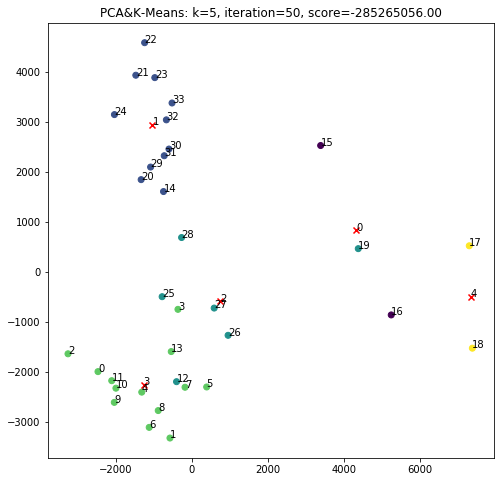

[major cluster]: [3 1 2]


In [3]:
# 비디오 ratio 결정
extractor.CONSTANT_RATIO = True
# 비디오 리사이즈
# extractor.resizeVideo(mode='crop') # mode: 'resize', 'crop'
# 비디오 전처리
extractor.preprocessVideo(merge_ratio_limit=.75, SHOW_IMAGE=True)
# 통계량 추출
extractor.getStatistics(SHOW_PLOT=False)
# 결과 이미지 영역 크롭
extractor.extractImages(interval=15, SHOW_IMAGE=True)

In [9]:
"""
폴더 전체 추출할때
비디오는 [rootPath]/videos 내에 있어야 한다
"""
rootPath = ".\\new-cosmetic-office"
for fileName in tqdm(os.listdir(os.path.join(rootPath, 'videos'))):
    print(os.path.splitext(fileName))
    extractor = ImageExtractor(rootPath, fileName)  
#     extractor.adjCenter = [extractor.videoWidth/2, extractor.videoHeight/2]
    # 비디오 ratio 결정
    extractor.CONSTANT_RATIO = True
    # 비디오 리사이즈
    extractor.resizeVideo()
    # 비디오 전처리
    extractor.preprocessVideo(merge_ratio_limit=0.75, SHOW_IMAGE=False)
    # 통계량 추출
    extractor.getStatistics(SHOW_PLOT=False)
    # 결과 이미지 영역 크롭
    extractor.extractImages(interval=15, SHOW_IMAGE=False)

A Jupyter Widget

('AHC-AGELESS REAL EYE CREAM FOR FACE', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\AHC-AGELESS REAL EYE CREAM FOR FACE.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\AHC-AGELESS REAL EYE CREAM FOR FACE.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\AHC-AGELESS REAL EYE CREAM FOR FACE.mp4


A Jupyter Widget

[Extract Images]: AHC-AGELESS REAL EYE CREAM FOR FACE


A Jupyter Widget

('AHC-Aura Secret Toneup Cream', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\AHC-Aura Secret Toneup Cream.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\AHC-Aura Secret Toneup Cream.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\AHC-Aura Secret Toneup Cream.mp4


A Jupyter Widget

[Extract Images]: AHC-Aura Secret Toneup Cream


A Jupyter Widget

('AHC-ONLY FOR MAN LOTION', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\AHC-ONLY FOR MAN LOTION.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\AHC-ONLY FOR MAN LOTION.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\AHC-ONLY FOR MAN LOTION.mp4


A Jupyter Widget

[Extract Images]: AHC-ONLY FOR MAN LOTION


A Jupyter Widget

('APIEU-데카소사이드 시카 겔 데이크림', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\APIEU-데카소사이드 시카 겔 데이크림.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\APIEU-데카소사이드 시카 겔 데이크림.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\APIEU-데카소사이드 시카 겔 데이크림.mp4


A Jupyter Widget

[Extract Images]: APIEU-데카소사이드 시카 겔 데이크림


A Jupyter Widget

('APIEU-스타트업 포어 프라이머', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\APIEU-스타트업 포어 프라이머.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\APIEU-스타트업 포어 프라이머.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\APIEU-스타트업 포어 프라이머.mp4


A Jupyter Widget

[Extract Images]: APIEU-스타트업 포어 프라이머


A Jupyter Widget

('BANILACO-프라임 프라이머 클래식', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\BANILACO-프라임 프라이머 클래식.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\BANILACO-프라임 프라이머 클래식.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\BANILACO-프라임 프라이머 클래식.mp4


A Jupyter Widget

[Extract Images]: BANILACO-프라임 프라이머 클래식


A Jupyter Widget

('BELIF-The true cream AQUA BOMB', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\BELIF-The true cream AQUA BOMB.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\BELIF-The true cream AQUA BOMB.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\BELIF-The true cream AQUA BOMB.mp4


A Jupyter Widget

[Extract Images]: BELIF-The true cream AQUA BOMB


A Jupyter Widget

('CLIO-스파클링 라인 프리즘 에어 아이섀도우', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\CLIO-스파클링 라인 프리즘 에어 아이섀도우.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\CLIO-스파클링 라인 프리즘 에어 아이섀도우.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\CLIO-스파클링 라인 프리즘 에어 아이섀도우.mp4


A Jupyter Widget

[Extract Images]: CLIO-스파클링 라인 프리즘 에어 아이섀도우


A Jupyter Widget

('FERRAGAMO-INCANTO CHARMS', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\FERRAGAMO-INCANTO CHARMS.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\FERRAGAMO-INCANTO CHARMS.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\FERRAGAMO-INCANTO CHARMS.mp4


A Jupyter Widget

[Extract Images]: FERRAGAMO-INCANTO CHARMS


A Jupyter Widget

('FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY.mp4


A Jupyter Widget

[Extract Images]: FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY


A Jupyter Widget

('FROMNATURE-에이지 인텐스 트리트먼트 에센스', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\FROMNATURE-에이지 인텐스 트리트먼트 에센스.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\FROMNATURE-에이지 인텐스 트리트먼트 에센스.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\FROMNATURE-에이지 인텐스 트리트먼트 에센스.mp4


A Jupyter Widget

[Extract Images]: FROMNATURE-에이지 인텐스 트리트먼트 에센스


A Jupyter Widget

('GENABELLE-LASOR SOOTHING SUNSCREEN', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\GENABELLE-LASOR SOOTHING SUNSCREEN.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\GENABELLE-LASOR SOOTHING SUNSCREEN.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\GENABELLE-LASOR SOOTHING SUNSCREEN.mp4


A Jupyter Widget

[Extract Images]: GENABELLE-LASOR SOOTHING SUNSCREEN


A Jupyter Widget

('GREEN FINGER-KIDS FACIAL LOTION', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\GREEN FINGER-KIDS FACIAL LOTION.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\GREEN FINGER-KIDS FACIAL LOTION.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\GREEN FINGER-KIDS FACIAL LOTION.mp4


A Jupyter Widget

[Extract Images]: GREEN FINGER-KIDS FACIAL LOTION


A Jupyter Widget

('HERA-BLACK CUSHION', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\HERA-BLACK CUSHION.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\HERA-BLACK CUSHION.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\HERA-BLACK CUSHION.mp4


A Jupyter Widget

[Extract Images]: HERA-BLACK CUSHION


A Jupyter Widget

('HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST.mp4


A Jupyter Widget

[Extract Images]: HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST


A Jupyter Widget

('ILLIYOON-세라마이드 아토 수딩 젤', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\ILLIYOON-세라마이드 아토 수딩 젤.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\ILLIYOON-세라마이드 아토 수딩 젤.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\ILLIYOON-세라마이드 아토 수딩 젤.mp4


A Jupyter Widget

[Extract Images]: ILLIYOON-세라마이드 아토 수딩 젤


A Jupyter Widget

('INNISFREE-ALOE REVITAL SOOTHING GEL', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\INNISFREE-ALOE REVITAL SOOTHING GEL.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\INNISFREE-ALOE REVITAL SOOTHING GEL.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\INNISFREE-ALOE REVITAL SOOTHING GEL.mp4


A Jupyter Widget

[Extract Images]: INNISFREE-ALOE REVITAL SOOTHING GEL


A Jupyter Widget

('INNISFREE-GREEN TEA SEED ESSENC IN LOTION', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\INNISFREE-GREEN TEA SEED ESSENC IN LOTION.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\INNISFREE-GREEN TEA SEED ESSENC IN LOTION.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\INNISFREE-GREEN TEA SEED ESSENC IN LOTION.mp4


A Jupyter Widget

[Extract Images]: INNISFREE-GREEN TEA SEED ESSENC IN LOTION


A Jupyter Widget

('INNISFREE-JEJU CHERRY BLOSSOM SKIN', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\INNISFREE-JEJU CHERRY BLOSSOM SKIN.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\INNISFREE-JEJU CHERRY BLOSSOM SKIN.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\INNISFREE-JEJU CHERRY BLOSSOM SKIN.mp4


A Jupyter Widget

[Extract Images]: INNISFREE-JEJU CHERRY BLOSSOM SKIN


A Jupyter Widget

('INNISFREE-NO SEBUM Mineral Powder', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\INNISFREE-NO SEBUM Mineral Powder.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\INNISFREE-NO SEBUM Mineral Powder.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\INNISFREE-NO SEBUM Mineral Powder.mp4


A Jupyter Widget

[Extract Images]: INNISFREE-NO SEBUM Mineral Powder


A Jupyter Widget

('INNISFREE-마이 블러셔 햇살 가득 장미', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\INNISFREE-마이 블러셔 햇살 가득 장미.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\INNISFREE-마이 블러셔 햇살 가득 장미.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\INNISFREE-마이 블러셔 햇살 가득 장미.mp4


A Jupyter Widget

[Extract Images]: INNISFREE-마이 블러셔 햇살 가득 장미


A Jupyter Widget

('ISOI-인텐시브 에너자이징크림', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\ISOI-인텐시브 에너자이징크림.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\ISOI-인텐시브 에너자이징크림.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\ISOI-인텐시브 에너자이징크림.mp4


A Jupyter Widget

[Extract Images]: ISOI-인텐시브 에너자이징크림


A Jupyter Widget

('MACQUEEN-쥬얼포텐 아이글리터', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\MACQUEEN-쥬얼포텐 아이글리터.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\MACQUEEN-쥬얼포텐 아이글리터.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\MACQUEEN-쥬얼포텐 아이글리터.mp4


A Jupyter Widget

[Extract Images]: MACQUEEN-쥬얼포텐 아이글리터


A Jupyter Widget

('MISSHA-레이어 블러링 모공커버 프라이머', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\MISSHA-레이어 블러링 모공커버 프라이머.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\MISSHA-레이어 블러링 모공커버 프라이머.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\MISSHA-레이어 블러링 모공커버 프라이머.mp4


A Jupyter Widget

[Extract Images]: MISSHA-레이어 블러링 모공커버 프라이머


A Jupyter Widget

('NEUTROGENA-HAND CREAM', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\NEUTROGENA-HAND CREAM.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\NEUTROGENA-HAND CREAM.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\NEUTROGENA-HAND CREAM.mp4


A Jupyter Widget

[Extract Images]: NEUTROGENA-HAND CREAM


A Jupyter Widget

('PERIPERA-핑크의순간 컬렉션 잉크 컬러 마스카라', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\PERIPERA-핑크의순간 컬렉션 잉크 컬러 마스카라.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\PERIPERA-핑크의순간 컬렉션 잉크 컬러 마스카라.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\PERIPERA-핑크의순간 컬렉션 잉크 컬러 마스카라.mp4


A Jupyter Widget

[Extract Images]: PERIPERA-핑크의순간 컬렉션 잉크 컬러 마스카라


A Jupyter Widget

('RIRE-BUBLE BUBLE LIP MASK', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\RIRE-BUBLE BUBLE LIP MASK.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\RIRE-BUBLE BUBLE LIP MASK.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\RIRE-BUBLE BUBLE LIP MASK.mp4


A Jupyter Widget

[Extract Images]: RIRE-BUBLE BUBLE LIP MASK


A Jupyter Widget

('ROKKISS-카렌듈라 에멀젼', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\ROKKISS-카렌듈라 에멀젼.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\ROKKISS-카렌듈라 에멀젼.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\ROKKISS-카렌듈라 에멀젼.mp4


A Jupyter Widget

[Extract Images]: ROKKISS-카렌듈라 에멀젼


A Jupyter Widget

('SENKA-PERFECT WHIP', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\SENKA-PERFECT WHIP.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\SENKA-PERFECT WHIP.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\SENKA-PERFECT WHIP.mp4


A Jupyter Widget

[Extract Images]: SENKA-PERFECT WHIP


A Jupyter Widget

('TONYMOLY-피키비키 아트 팝 코렉팅 베이스', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\TONYMOLY-피키비키 아트 팝 코렉팅 베이스.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\TONYMOLY-피키비키 아트 팝 코렉팅 베이스.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\TONYMOLY-피키비키 아트 팝 코렉팅 베이스.mp4


A Jupyter Widget

[Extract Images]: TONYMOLY-피키비키 아트 팝 코렉팅 베이스


A Jupyter Widget

('VICHY-오 떼르말 미네랄 온천수 미스트', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\VICHY-오 떼르말 미네랄 온천수 미스트.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\VICHY-오 떼르말 미네랄 온천수 미스트.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\VICHY-오 떼르말 미네랄 온천수 미스트.mp4


A Jupyter Widget

[Extract Images]: VICHY-오 떼르말 미네랄 온천수 미스트


A Jupyter Widget

In [6]:
extractor.cap.release()
cv2.destroyAllWindows()      

In [14]:
"""
비디오 전체 이미지 샘플링
"""
rootPath = ".\\new-cosmetic-office"
for fileName in tqdm(os.listdir(os.path.join(rootPath, 'videos_resized'))):
    fn, ext =  os.path.splitext(fileName)
    imgExtDirPath = os.path.join(rootPath, "images_full", fn)
    print(fn)
    cap = cv2.VideoCapture(os.path.join(rootPath, 'videos_resized', fileName))
    idx = 0
    cnt = 0
    imgDirOrig = imgExtDirPath
    if not os.path.isdir(imgDirOrig): os.makedirs(imgDirOrig)            
    imgDirTemp = os.path.join(rootPath, "temp")
    if not os.path.isdir(imgDirTemp): os.makedirs(imgDirTemp)
    while(True):
        ret, frame = cap.read()
        if ret:            
            cnt += 1
            if(cnt%20==0):
                try:
                    imgPathOrig = os.path.join(imgDirOrig, str(fn)+'_'+str(idx)+'.jpg')    
                    imgPath = os.path.join(imgDirTemp, "temp"+'_'+str(idx)+'.jpg')
                    cv2.imwrite(imgPath, frame) # 이미지 저장
                    os.rename(imgPath, imgPathOrig) #  opencv 한글 패스 저장 안되므로 temp에 만들고 이름 수정 
                    idx+=1
                except:
                    print('[Save Img Error:]', imgPath)            
        else: break
    cap.release()
    shutil.rmtree(imgDirTemp)

A Jupyter Widget

AHC-AGELESS REAL EYE CREAM FOR FACE
AHC-Aura Secret Toneup Cream
AHC-ONLY FOR MAN LOTION
APIEU-데카소사이드 시카 겔 데이크림
APIEU-스타트업 포어 프라이머
BANILACO-프라임 프라이머 클래식
BELIF-The true cream AQUA BOMB
CLIO-스파클링 라인 프리즘 에어 아이섀도우
FERRAGAMO-INCANTO CHARMS
FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY
FROMNATURE-에이지 인텐스 트리트먼트 에센스
GENABELLE-LASOR SOOTHING SUNSCREEN
GREEN FINGER-KIDS FACIAL LOTION
HERA-BLACK CUSHION
HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST
ILLIYOON-세라마이드 아토 수딩 젤
INNISFREE-ALOE REVITAL SOOTHING GEL
INNISFREE-GREEN TEA SEED ESSENC IN LOTION
INNISFREE-JEJU CHERRY BLOSSOM SKIN
INNISFREE-NO SEBUM Mineral Powder
INNISFREE-마이 블러셔 햇살 가득 장미
ISOI-인텐시브 에너자이징크림
MACQUEEN-쥬얼포텐 아이글리터
MISSHA-레이어 블러링 모공커버 프라이머
NEUTROGENA-HAND CREAM
PERIPERA-핑크의순간 컬렉션 잉크 컬러 마스카라
RIRE-BUBLE BUBLE LIP MASK
ROKKISS-카렌듈라 에멀젼
SENKA-PERFECT WHIP
TONYMOLY-피키비키 아트 팝 코렉팅 베이스
VICHY-오 떼르말 미네랄 온천수 미스트



---
# CLASS

In [581]:
# input1 = torch.randn(50000, 1280).to('cuda')
# input2 = torch.randn(1280).to('cuda')
%time output = (input1-input2).norm(dim=1)
%time output.sort()
%time output.argmax(dim=0)

"""
roi하나당 1ms정도 나오네...
100개 쓰면 100ms... 느려 너무
"""

Wall time: 0 ns
Wall time: 1 ms
Wall time: 0 ns


'\nroi하나당 1ms정도 나오네...\n100개 쓰면 100ms... 느려 너무\n'

In [554]:
# %time input1 = torch.randn(50000, 1280)
# %time input2 = torch.randn(1280).unsqueeze(0)
input3 = input2.unsqueeze(0)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
%time output = cos(input1, input3)
output.shape

Wall time: 999 µs


torch.Size([50000])

In [32]:
net = torchvision.models.resnet50(pretrained=False)
net = torch.nn.DataParallel(net).cuda()
checkpoint = torch.load('torch_models/shape/resnet50_trained_on_SIN.pth.tar')
net.load_state_dict(checkpoint['state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [3]:
net = torch.load("torch_models/cutmix-res50.pth.tar")
# net

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os, shutil
from time import sleep
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from torch.distributions.multivariate_normal import MultivariateNormal
from tqdm import tqdm
# import mymodels
# from mymodels.BN_Inception import BN_Inception

def my_cos(x,y):
    _x = F.normalize(x, p=2, dim=1)
    _y = F.normalize(y, p=2, dim=1)
    return _x.matmul(_y.transpose(0,1))

class Flatten(torch.nn.Module):
    """
    torch.nn.Sequential에서 사용가능한 flatten 모듈
    """
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
    
class OracleModel(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(OracleModel, self).__init__()
#         ****torch pretrained net****
#         net = models.shufflenetv2.shufflenet_v2_x1_0(pretrained=True) # 1024
#         net = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
#         net = models.mobilenet_v2(pretrained=True)
#         net = models.densenet201(pretrained=True)
        net = models.resnet50(pretrained=True)

        modules = list(net.children())[:-2]      # resnet conv_5
        self.backbone = torch.nn.Sequential(*modules) # 2048
        avg_pool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        flatten = Flatten() 
        
#         net = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, 
#                                                              pretrained_backbone=True)   
#         self.backbone = net.backbone #256 


# #         ****mobilenet****
#         self.BACKBONE_PATH = 'torch_models/mobile_ft.pt'
#         mobilenet = torch.load(self.BACKBONE_PATH)
#         modules = list(mobilenet.children())[:-1]
#         avg_pool = torch.nn.AvgPool2d(7, stride=1)
#         flatten = Flatten()
#         self.backbone = torch.nn.Sequential(*modules, avg_pool, flatten) #1280
        
# #         ****mobilnet distance matric learning****   
#         self.BACKBONE_PATH = 'mymodels/model_000400.pth'
#         self.backbone = torch.load(self.BACKBONE_PATH) #1280    

#         self.backbone = mymodels.create('Resnet50', dim=512, pretrained=True,
#                                         model_path='mymodels/ckp_ep210.pth.tar') #[227,227]->512

#         self.backbone = BN_Inception(dim=512, pretrained=True, 
#                                      model_path='mymodels/bn_inception-52deb4733.pth')

        # fc layer
        self.fc = nn.Sequential(
            avg_pool,
            flatten
        ) # 2048
        
#         self.embed = nn.Sequential(
#             self.backbone,
#             self.fc
#         ) # 2048
    
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.topk = 3
        self.threshold = 0.75
        self.feature_len = 2048

        self.sort_order_descending = False
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.roi_upsample = nn.UpsamplingBilinear2d([224,224])
        self.roi_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
        
    def embed(self, images):
        r = self(images)
        return self.fc(r)

    def forward(self, images):
        """Extract feature vectors from input images."""
        return self.backbone(images)
#         return self.backbone(images)[0]    
    

    def makeAllReference_online(self, referenceImgDirPath):
        """
        임베딩 디비 생성... flask 서버용 
        utils.makeAllReferenceCSV 에서 csv 저장만 안함
        """
        reference_dataset = torchvision.datasets.ImageFolder(
            root=referenceImgDirPath,
            transform=transforms.Compose([
                transforms.Resize([224,224]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        )
        reference_loader = torch.utils.data.DataLoader(
            reference_dataset,
            batch_size=32,
            num_workers=0,
            shuffle=False
        )
        
        # get all data and input to model
        _temp = []
        for data, target in tqdm(reference_loader):
            outputs = self.embed(data.to(self.device)).data # .data 안하면 메모리 오버플로남...
            _temp.append(outputs)

        represented = torch.cat(_temp, dim=0)
        # raw data label 별 평균 구해두기
        self.df_ref_online = pd.DataFrame(represented.cpu().numpy())
        self.df_ref_online['label'] = [reference_dataset.classes[i] for i in reference_dataset.targets]
        self.reference_means_online = self.df_ref_online.groupby('label').mean()
        self.dir_list_online = reference_dataset.classes

        # 즉각 임베딩 디비 생성
        self.setReferenceDataset(self.dir_list_online, self.df_ref_online, self.reference_means_online)
        return self.dir_list_online, self.df_ref_online, self.reference_means_online

    def addNewData_online(self, im_arr, label):
        """
        @params im_arr: h X w X 3 (RGB)
        @params label: "praL"
        """
        data = self.roi_transform(im_arr).unsqueeze(0)
        outputs = self.embed(data.to(self.device)).data
        new_feature = list(outputs.squeeze().cpu().numpy())
        new_feature.append(label)
        new_feature[-1]
        # concat to prev df_ref_online
        self.df_ref_online.loc[self.df_ref_online.shape[0]] = new_feature
        # revise reference_means_online 
        self.reference_means_online = self.df_ref_online.groupby('label').mean()
        # 즉각 임베딩 디비 생성
        self.setReferenceDataset(self.dir_list_online, self.df_ref_online, self.reference_means_online)
        print('[Detector]: addNewData_online -', label)
        return

    def addNewLabel_online(self, dirPath, label):   
        """
        @params dirPath: "server/vu-visor/static/images_ext"
        @params label: "praL"
        """
        finalDirPath = os.path.join(dirPath, label)
        ims = [Image.open(os.path.join(finalDirPath,i)) for i in os.listdir(finalDirPath)] # n_img X h X w X c
        ims_tensor = torch.stack([self.roi_transform(im) for im in ims])
        outputs = self.embed(ims_tensor.to(self.device)).data
        new_features =outputs.cpu().numpy() # n_img X 2048

        new_df_ref_online = pd.DataFrame(new_features)
        new_df_ref_online['label'] = label
        # add new label
        if label not in self.dir_list_online: # 중복된 이름 없을 시 새로 등록
            self.dir_list_online.append(label)
            self.dir_list_online.sort() # 반드시 소팅해서 클래스 번호 재정렬 해줘야함
        # concat to prev df_ref_online
        _df_ref_online_non_overlap = self.df_ref_online[self.df_ref_online['label']!=label] # 중복된 이전 데이터 제거
        self.df_ref_online = pd.concat([_df_ref_online_non_overlap, new_df_ref_online], ignore_index=True)
        # revise reference_means_online 
        self.reference_means_online = self.df_ref_online.groupby('label').mean()
        # 즉각 임베딩 디비 생성
        self.setReferenceDataset(self.dir_list_online, self.df_ref_online, self.reference_means_online)
        print('[Detector]: addNewLabel_online -', label)
        return 
        
    # 임베딩 디비 생성
    def setReferenceDataset(self, sample_dir_list, df_ref_feature_sampled, reference_means_sampled):
        self.reference_classes = sample_dir_list
        self.reference_targets = list(df_ref_feature_sampled.iloc[:,-1])
        self.embedded_features_cpu = torch.tensor(df_ref_feature_sampled.iloc[:,:-1].as_matrix()).float().data # float64->float32(torch default), cpu
        self.embedded_features = self.embedded_features_cpu.to(self.device) # gpu
        self.embedded_means_numpy = reference_means_sampled.as_matrix()
        self.embedded_means = torch.tensor(self.embedded_means_numpy).float().data.to(self.device) # float64->float32(torch default), gpu

        self.c2i = {c:i for i,c in enumerate(self.reference_classes)}
        self.embedded_labels = torch.tensor([self.c2i[c] for c in self.reference_targets]).to(self.device)
        
        # make datafames for plot
        # ***필요없음 어차피 pca 해야함
        self.df_ = pd.DataFrame(np.array(self.embedded_features_cpu))
        self.df_['name'] = self.reference_targets
        self.centers_ = pd.DataFrame(self.embedded_means_numpy)
        self.centers_['name'] = self.reference_classes

    def fit_pca(self, n_components=4):
        # pca model fit
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components) # 2048 차원 다쓰면 나중에 샘플링에서 계산 오류남, sample 개수보다 많으면 촐레스키 분해 에러나는듯
        self.transformed = self.pca.fit_transform(self.embedded_features_cpu)

        # show PCA features 
        self.df = pd.DataFrame(self.transformed)
        self.df['name'] = self.reference_targets
        self.centers = pd.DataFrame(self.pca.transform(self.embedded_means_numpy))
        self.centers['name'] = self.reference_classes

    def inference_tensor3(self, inputs, metric='cos', knn=True):
        """
        roi 피처맵을(nxcx7x7) 인풋으로 받음
        @params metric: [l2, mahalanobis, prob]
        @params inputs: # N x C x H x W
        """            
        # inputs shape: Batch*C*H*W
        # input to backbone model
        self.inputs = inputs
        self.outputs = self.fc(self.inputs).data # n_roi X features 2048    

        # inference
        self.sort_order_descending = True         
        if knn: self.dists = my_cos(self.outputs, self.embedded_features)
        else: self.dists = my_cos(self.outputs, self.embedded_means)

        self.dists_sorted = self.dists.sort(dim=1, descending=self.sort_order_descending)
        if knn: self.predicts = self.embedded_labels[self.dists_sorted.indices][:,:self.topk]
        else: self.predicts = self.dists_sorted.indices[:,:self.topk]

        self.predicts_dist = self.dists_sorted.values[:,:self.topk]
        return self.predicts.data, self.predicts_dist.data    

    def inference_tensor4(self, inputs):
        """
        roi 피처맵을(nxcx7x7) 인풋으로 받음
        """            
        # inputs shape: Batch*C*H*W
        # input to backbone model
        self.inputs = inputs
        self.outputs = self.fc(self.inputs).data # n_roi X features 2048    

        # inference
        self.dists = my_cos(self.outputs, self.embedded_means)
        self.predicts_dist = self.dists
        return self.predicts_dist.data    

    # 각 레이블 별 평균과의 L2 거리 계산 (PCA 적용안함)
    def calc_l2(self, label):
        mu = self.embedded_means[label]
        xx = self.outputs

        # 20*1280 X 1280*20 --diag--> 20
        # num_roi*dim X dim*num_roi --diag--> num_roi
        xx_sub_mu = xx.sub(mu)
        l2_dist = xx_sub_mu.matmul(xx_sub_mu.t()).sqrt().diag()
        return l2_dist.cpu()

    # 각 레이블 별 평균과의 cosine simility 계산 (PCA 적용안함)
    def calc_cos(self, label):
        mu = self.embedded_means[label]
        xx = self.outputs

        # 20*1280 X 1280*20 --diag--> 20
        # num_roi*dim X dim*num_roi --diag--> num_roi
        mu = mu.unsqueeze(0)
        cos_dist = self.cos(xx, mu)
        return cos_dist.cpu()        

    def inference_file(self, imgPath):              
        # imgPath = "./server/oracle_proj/predict.jpg"
        frame = cv2.imread(os.path.join(imgPath), cv2.IMREAD_COLOR)
        return self.inference_tensor(frame)

    def show_img(self, imgPath):
        frame = cv2.imread(os.path.join(imgPath), cv2.IMREAD_COLOR)
        # opencv frme input // H*W*C(BGR)
        # 0-255 3 channel
        inputs = torch.Tensor(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))/255 # 여기 Tensor 소문자로 바꾸면 안됨... 차이 알아보기
        plt.imshow(inputs)
        plt.show()
        
    def show_tensor(self, t):
        plt.imshow(t.numpy().transpose([1,2,0]))
        plt.show()
        
    def plot(self):
        self.fit_pca(n_components=4)
        _outputs = self.pca.transform(self.outputs.cpu())

        plt.figure(figsize=(18,9))
        plt.title("Vector space, pca_n: "+str(self.feature_len))
        ax = sns.scatterplot(x=0, y=1, hue='name', data=self.df, palette="Set1", legend="full")
        ax2 = sns.scatterplot(x=0, y=1, hue='name', data=self.centers, palette="Set1", s=150, legend=None, edgecolor='black')
        plt.scatter(_outputs[:,0], _outputs[:,1], marker='x', c='black')
        plt.show()

    # save plot image for web
    def save_plot(self, plotPath):
        self.fit_pca(n_components=4)
        _outputs = self.pca.transform(self.outputs.cpu())

        plt.figure(figsize=(9,9))
        plt.title("Vector space, pca_n: "+str(self.feature_len))
        ax = sns.scatterplot(x=0, y=1, hue='name', data=self.df, palette="Set1", legend="full", s=30)
        ax2 = sns.scatterplot(x=0, y=1, hue='name', data=self.centers, palette="Set1", s=150, legend=None, edgecolor='black')
        plt.scatter(_outputs[:,0], _outputs[:,1], marker='x', c='black', s=120)
        plt.savefig(plotPath)

In [4]:
model = OracleModel()
model.to(model.device)
model.eval()

OracleModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [5]:
"""
차후 util로 리팩토링
"""
import PIL
# -------------- 전체 임베딩 피처 디비 생성 --------------
def makeAllReferenceCSV(referenceImgDirPath, featuresPath, meanPath):
    """
    전체 임베딩 피처 dataframe 생성 후 csv로 저장
    """
    reference_dataset = torchvision.datasets.ImageFolder(
        root=referenceImgDirPath,
        transform=transforms.Compose([
#             transforms.Resize([224,224]),
            transforms.RandomHorizontalFlip(),
#             transforms.RandomRotation(45),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    )
    reference_loader = torch.utils.data.DataLoader(
        reference_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=False
    )

    
#     # *********************cifar10***********************
#     reference_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=False, 
#             transform=transforms.Compose([
#             transforms.Resize([224,224]),
#             transforms.RandomHorizontalFlip(),
# #             transforms.RandomRotation(45),
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#         ]))
#     reference_loader = torch.utils.data.DataLoader(reference_dataset, batch_size=8,
#                                               shuffle=False, num_workers=4)
#     # *********************cifar10***********************

    # get all data and input to model
    _temp = []
    for data, target in tqdm(reference_loader):
        outputs = model.embed(data.to(model.device)).data # .data 안하면 메모리 오버플로남...
        _temp.append(outputs)       

    represented = torch.cat(_temp, dim=0)
    # raw data label 별 평균 구해두기
    df_ref = pd.DataFrame(represented.cpu().numpy())
    df_ref['label'] = [reference_dataset.classes[i] for i in reference_dataset.targets*1]
    reference_means = df_ref.groupby('label').mean()

    # 자료 저장
    df_ref.to_csv(featuresPath, encoding='utf8', index=False)
    reference_means.to_csv(meanPath, encoding='utf8', index=True)
    return


def set_sample_val_img(imgValPath, imgValTempPath, n_class_for_val, musthave_list=[]):
    """
    n개 클래스만 validation 샘플링 하는 함수
    @param imgValPath = '.\\img_real\\val'
    @param imgValTempPath = '.\\img_real\\_val_temp'
    @param n_class_for_val = 20
    @musthave_list = 반드시 포함할 리스트
    """
    all_dir_list = os.listdir(imgValPath)
    sample_dir_list = np.random.permutation(all_dir_list)[:n_class_for_val]
    for i in musthave_list:
        if i not in sample_dir_list: sample_dir_list = np.concatenate([sample_dir_list, [i]])

    # 추출될 이미지 저장 폴더 비우기... 비동기 버그 때문에 sleep넣음 
    if os.path.isdir(imgValTempPath): shutil.rmtree(imgValTempPath)
    sleep(0.1)
    os.makedirs(imgValTempPath)

    # copy sampled dir
    for class_name in tqdm(sample_dir_list):
        if not os.path.isdir(os.path.join(imgValTempPath, class_name)):
            os.mkdir(os.path.join(imgValTempPath, class_name))
        command = ['cmd', '\/c', 'copy',  os.path.join(imgValPath, class_name) , os.path.join(imgValTempPath, class_name)]    
        subprocess.check_output(command)
    sample_dir_list.sort() # 토치 데이터로더도 자동으로 이름순 소팅하므로 꼭 해야함
    return list(sample_dir_list)

def get_sample_reference(sample_dir_list, featuresPath, meanPath, showData=False):
    """
    n개 클래스 임베딩 & 레이블 & means 추출 
    """
    # load saved embedding features & means
    df_ref = pd.read_csv(featuresPath, encoding='utf8')
    reference_means = pd.read_csv(meanPath, encoding='utf8', index_col='label')
    
    if showData:
        display(df_ref)
        display(reference_means)

    df_ref_featere_sampled = None
    for c in sample_dir_list:
        _df = df_ref[df_ref['label'] == c]
        if df_ref_featere_sampled is None: df_ref_featere_sampled = _df
        else: df_ref_featere_sampled = df_ref_featere_sampled.append(_df)

    df_ref_featere_sampled = df_ref_featere_sampled.reset_index(drop=True)
    reference_means_sampled = reference_means.loc[sample_dir_list]
    return df_ref_featere_sampled, reference_means_sampled


In [69]:
"""
전체 피처 데이터 재생성
"""
# referenceImgDirPath = '.\\img4\\train'
referenceImgDirPath = '.\\img_real2\\ref'

featuresPath = 'reference_features_cos.csv'
meanPath = 'reference_means_cos.csv'
makeAllReferenceCSV(referenceImgDirPath, featuresPath, meanPath)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:04<00:00,  9.92it/s]


In [4]:
%%time
print('**********data folder re-generating***********')
imgValPath = '.\\img_real2\\val2'
# imgValPath = '.\\img4\\val'
imgValTempPath = '.\\img_real2\\_val_temp'
n_class_for_val = 100
# musthave_list = ['LG-praL']
musthave_list = []

# -------------- n개 클래스만 validation 샘플링 세팅 및 폴더정리 ----------------
reference_dataset = torchvision.datasets.ImageFolder(
    root=imgValPath,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)
sample_dir_list = reference_dataset.classes
# sample_dir_list = set_sample_val_img(imgValPath, imgValTempPath, n_class_for_val, musthave_list)

# # *********************cifar10***********************
# val_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=False,
#         transform=transforms.Compose([
#         transforms.Resize([224,224]),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]))
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32,
#                                          shuffle=True, num_workers=4)
# sample_dir_list = val_dataset.classes
# # *********************cifar10***********************

# -------------- 레퍼런스 데이터에서 n개 클래스 임베딩 & 레이블 & means 추출 -----------------
featuresPath = 'reference_features_cos.csv'
meanPath = 'reference_means_cos.csv'

df_ref_featere_sampled, reference_means_sampled = get_sample_reference(sample_dir_list, featuresPath, meanPath, showData=True)

# ---------------------------- 레퍼런스셋 로드 및 임베딩 세팅 ---------------------------------
model.setReferenceDataset(sample_dir_list, df_ref_featere_sampled, reference_means_sampled)

**********data folder re-generating***********


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,label
0,0.746052,-0.238199,0.344084,0.205748,-0.697707,0.211390,-0.321975,0.953983,0.032778,1.450020,...,-0.277319,0.331930,0.651141,0.515689,0.832175,0.336853,0.441441,-0.328972,-0.129308,APIEU-데카소사이드 시카 겔 데이크림
1,0.864508,-0.416327,0.336972,0.022675,-0.472853,0.361049,-0.345910,0.942148,0.114183,1.346108,...,-0.389744,0.232526,0.424407,0.268293,0.539018,0.222761,0.391434,-0.006029,-0.794955,APIEU-데카소사이드 시카 겔 데이크림
2,0.760171,-0.144353,0.579403,-0.088211,-0.567115,0.263357,-0.399798,0.952551,0.138181,1.322992,...,-0.435233,0.282436,0.521947,0.036464,0.678995,0.262214,0.365306,-0.155067,-0.556287,APIEU-데카소사이드 시카 겔 데이크림
3,0.745133,-0.234060,0.508286,-0.055144,-0.520900,0.245014,-0.386938,0.936534,0.151141,1.238534,...,-0.445666,0.128520,0.412363,0.116766,0.534154,0.327727,0.397089,-0.081617,-0.584893,APIEU-데카소사이드 시카 겔 데이크림
4,0.828818,-0.111888,0.204724,0.172493,-0.726119,0.277498,-0.296689,0.846686,0.054786,1.307179,...,-0.427846,0.137546,0.200860,0.266583,0.527680,0.282421,0.319349,-0.017656,-0.653964,APIEU-데카소사이드 시카 겔 데이크림
5,1.030867,-0.201070,0.292107,-0.009572,-0.403850,0.595738,-0.465443,0.917855,-0.042633,1.347944,...,-0.183606,0.215585,0.493269,0.392019,0.599022,0.151644,0.609103,-0.086990,-0.661677,APIEU-데카소사이드 시카 겔 데이크림
6,0.981823,-0.638066,0.088084,0.169529,-0.596574,0.679308,-0.380833,1.103060,-0.088971,1.612676,...,-0.340332,0.481754,0.582183,0.593359,0.686747,0.180405,0.463299,-0.407524,-0.735238,APIEU-데카소사이드 시카 겔 데이크림
7,1.218703,-0.708512,0.423938,-0.057767,-0.539377,0.815925,-0.426246,0.878697,0.101341,1.691410,...,-0.387898,0.598427,0.942199,0.452896,0.818392,0.229019,0.360627,-0.559206,-0.728391,APIEU-데카소사이드 시카 겔 데이크림
8,1.149192,-0.660410,0.396876,-0.069846,-0.561082,0.631766,-0.556256,0.899291,-0.016765,1.641944,...,-0.297797,0.595305,0.950856,0.252728,0.790667,0.134585,0.489659,-0.627534,-0.899025,APIEU-데카소사이드 시카 겔 데이크림
9,1.103893,-0.685949,0.099193,-0.070604,-0.721136,0.703790,-0.309468,0.848037,-0.127460,1.493589,...,-0.234793,0.375547,0.729171,0.245892,0.452025,0.267206,0.421042,-0.487150,-0.820257,APIEU-데카소사이드 시카 겔 데이크림


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
label,,,,,,,,,,,,,,,,,,,,,
APIEU-데카소사이드 시카 겔 데이크림,0.954636,-0.405389,0.381520,-0.038074,-0.521394,0.468285,-0.432202,1.013711,-0.098281,1.522254,...,-0.521992,-0.248922,0.299179,0.713937,0.271834,0.638049,0.247252,0.390370,-0.422226,-0.674066
APIEU-스타트업 포어 프라이머,1.058143,-0.313253,0.239058,-0.026115,-0.655725,0.626184,-0.342307,0.976689,-0.298868,1.586709,...,-0.664334,-0.188668,0.264976,0.909411,0.219575,0.648550,0.226866,0.431748,-0.511425,-0.772201
BELIF-The true cream AQUA BOMB,1.026745,-0.328277,0.397921,-0.186102,-0.186949,0.567078,-0.382215,1.233955,-0.124719,1.360055,...,-0.374035,-0.106977,0.262964,0.824852,0.394172,0.750942,0.229601,0.447949,-0.305211,-0.892517
CLIO-스파클링 라인 프리즘 에어 아이섀도우,1.012070,-0.206523,0.319732,-0.381119,-0.076504,0.632657,-0.427212,1.269623,-0.338117,1.503578,...,-0.440473,0.030990,0.072688,1.174175,0.324356,0.577386,0.209526,0.519254,-0.563230,-0.700358
FERRAGAMO-INCANTO CHARMS,0.663221,-0.241388,0.450942,-0.244086,-0.223550,0.295498,-0.213242,1.029472,-0.233642,1.442333,...,-0.511184,-0.202842,-0.182760,0.770377,0.150501,0.500843,0.171700,0.510769,-0.405433,-1.115910
FROMNATURE-에이지 인텐스 트리트먼트 에센스,1.079780,-0.397444,0.284531,-0.095544,-0.426295,0.663996,-0.382083,1.036030,-0.106660,1.166459,...,-0.546814,-0.325099,0.268457,0.569500,0.390412,0.552483,0.086636,0.692921,-0.156065,-0.581013
GENABELLE-LASOR SOOTHING SUNSCREEN,1.352799,-0.343991,0.293821,-0.164406,-0.551341,0.562764,-0.460774,0.968476,-0.147720,1.534125,...,-0.599016,-0.101491,0.501621,0.862913,0.366391,0.619370,0.194199,0.576553,-0.281272,-0.812866
ILLIYOON-세라마이드 아토 수딩 젤,1.276282,-0.038361,0.340350,-0.260335,-0.584034,0.517524,-0.380524,1.016354,-0.045433,1.236234,...,-0.524042,-0.265275,0.330396,0.741835,0.304810,0.695039,0.070159,0.590303,-0.201844,-0.681555
INNISFREE-NO SEBUM Mineral Powder,0.989095,-0.304263,0.586826,-0.225104,-0.267663,0.297627,-0.495289,1.128783,-0.258872,1.809451,...,-0.504680,-0.179566,0.316089,0.854042,0.163578,0.894606,0.189685,0.351746,-0.560521,-1.195378


Wall time: 267 ms


In [75]:
# ---------------------------- validation set 로드 ---------------------------------
val_dataset = torchvision.datasets.ImageFolder(
    root=imgValTempPath,
    transform=transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=True
)

assert val_dataset.classes==sample_dir_list, "샘플링 클래스와 데이터로더 클래스가 다름"
# ---------------------------- validation set 정확도 측정 ---------------------------------
print('**********calculating***********')

target_all = []
preds_all = []
for data, target in tqdm(val_loader):
    data = data.to(model.device)
    preds, preds_dist = model.inference_tensor3(model(data).data, 'cos', knn=False)
    target_all.append(target)
    preds_all.append(preds)
    

target_all=torch.cat(target_all, dim=0)
preds_all=torch.cat(preds_all, dim=0).data.cpu()
top1_acc = target_all.eq(preds_all[:,0]).float().mean()
top3_acc = np.mean([t in p for t,p in zip(target_all, preds_all)])

# groupby 통계량 보기
_res = []
for t,p in zip(target_all.numpy(), preds_all.numpy()):
    _res.append([val_dataset.classes[t],t,p,t==p[0], t in p])
_df_res = pd.DataFrame(_res, columns=['label', 'target', 'pred', 'top1', 'top3'])
res_agg_df = _df_res.groupby('label').mean()
res_agg_df['count'] = list(_df_res.groupby('target').count()['label'])

display(res_agg_df)
print("[top-1 acc]:", top1_acc, " [top-3 acc]:", top3_acc, " [all count]:",len(target_all))

**********calculating***********


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.95it/s]


,target,top1,top3,count
label,,,,
APIEU-데카소사이드 시카 겔 데이크림,0,0.240741,0.796296,54
APIEU-스타트업 포어 프라이머,1,0.491525,0.813559,59
BELIF-The true cream AQUA BOMB,2,0.206897,0.775862,58
CLIO-스파클링 라인 프리즘 에어 아이섀도우,3,0.828125,0.906250,64
FERRAGAMO-INCANTO CHARMS,4,0.836066,0.901639,61
FROMNATURE-에이지 인텐스 트리트먼트 에센스,5,0.176471,0.450980,51
GENABELLE-LASOR SOOTHING SUNSCREEN,6,0.492537,0.791045,67
ILLIYOON-세라마이드 아토 수딩 젤,7,0.305085,0.593220,59
INNISFREE-NO SEBUM Mineral Powder,8,0.560606,0.787879,66


[top-1 acc]: tensor(0.4013)  [top-3 acc]: 0.6350053361792957  [all count]: 937


In [72]:
res_agg_df.loc['LG-praL']

KeyError: 'the label [LG-praL] is not in the [index]'

Wall time: 23.8 s


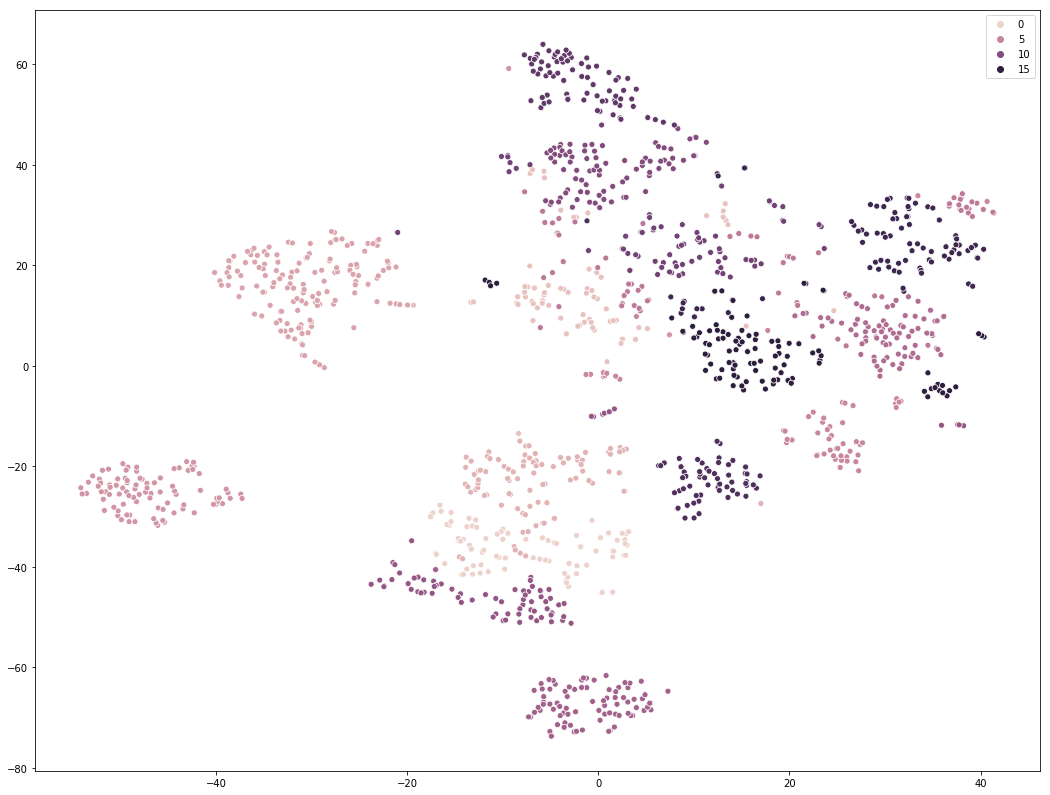

In [73]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

_model = TSNE()
feature = df_ref_featere_sampled.iloc[:,:-1]
%time transformed = _model.fit_transform(feature)

xs = transformed[:,0]
ys = transformed[:,1]
plt.figure(figsize=(18,14))
sns.scatterplot(x=xs, y=ys,
                     hue=pd.factorize(df_ref_featere_sampled['label'])[0])
plt.show()

In [37]:
from torchsummary import summary
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
# model = ().to(device)

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [19]:
%time preds, preds_dist = model.inference_tensor3(data.to(model.device), 'cos')

Wall time: 18 ms


array([ 0,  0,  0, ..., 98, 98, 98])

---
## +RPN

In [32]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import torchvision
# from RoIAlign.roi_align import RoIAlign      # RoIAlign module
# from RoIAlign.roi_align import CropAndResizeFunction # crop_and_resize module
import cv2
import numpy as np
import pandas as pd
import os, shutil
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

def get_rois(images, featuremaps, bboxes):
    """
    roi-align from feature map
    @params images - 원본 이미지 (사이즈 계산용)
    @params featuremaps - CNN Backbone 거쳐 나온 것
    @params bboxes - 원본 이미지에서의 bboxes (x,y,w,h)
    @return 피처맵에서 스케일된 bbox부분 7x7로 roi-align된 피처맵
    """
    # calc bbox ratio
    ratio_y = featuremaps.shape[2]/images.shape[2]
    ratio_x = featuremaps.shape[3]/images.shape[3]
    bboxes_scaled = bboxes.clone()#.detach()

    bboxes_scaled[:,0] = bboxes_scaled[:,0]*ratio_x # for x
    bboxes_scaled[:,1] = bboxes_scaled[:,1]*ratio_y # for y
    bboxes_scaled[:,2] = bboxes_scaled[:,2]*ratio_x # for w
    bboxes_scaled[:,3] = bboxes_scaled[:,3]*ratio_y # for h

    # x,y,w,h -> x1, y1, x2, y2 그래디언트 학습되는 변수가 아니므로 inplace 계산 들어가도 괜찮다
    bboxes_scaled[:, 2] = bboxes_scaled[:, 0] + bboxes_scaled[:, 2]
    bboxes_scaled[:, 3] = bboxes_scaled[:, 1] + bboxes_scaled[:, 3]
    crops = torchvision.ops.roi_align(featuremaps, [bboxes_scaled], [7,7])
    return crops

class Flatten(torch.nn.Module):
    """
    torch.nn.Sequential에서 사용가능한 flatten 모듈
    """
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
    
class UBBR(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(UBBR, self).__init__()
#         ****torch pretrained net****
        net = models.resnet50(pretrained=True)
#         modules = list(net.children())[:-3]      # delete all untill Conv_4 layer. - 1024
        modules = list(net.children())[:-2]      # delete all untill Conv_5 layer. - 2048
        avg_pool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        flatten = Flatten()
        self.backbone = torch.nn.Sequential(*modules) #1024
#         self.backbone = torch.nn.Sequential(*modules, avg_pool, flatten) #1024
    
        # RoIAlign layer
#         self.roi_align = RoIAlign(7, 7) #.to('cuda')
#         self.roi_upsample = nn.UpsamplingBilinear2d([7,7]) # roi-align 대용
        
        # fc layer
        self.fc = nn.Sequential(
#             nn.Conv2d(1024, 16, kernel_size=(1, 1), stride=(1, 1), bias=False),
#             nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            flatten,
            nn.ReLU(),
            nn.Linear(7*7*16, 256, bias=True),
            nn.ReLU(),
            nn.Linear(256, 4, bias=True),
        )
        
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.roi_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
        
    def forward(self, images, boxes):
        """Extract feature vectors from input images."""
        # CNN backbone
        featuremaps = self.backbone(images)
        
        crops = get_rois(images, featuremaps, boxes)
        
        # fc layer
        offsets = self.fc(crops) 
        return offsets
    
def regression_transform(bboxes, offsets):
    """
    clac bboxes_adj using offsets
    @params bboxes_adj - N x 4 float tensor
    @params offsets - N x 4 float tensor
    """
    bboxes_adj = bboxes.clone().detach()
    # w,h -> x,y 
    # w,h 값이 x,y계산에 들어가므로 계산순서 바뀌면 안됨
    bboxes[:,2] = bboxes_adj[:,2]/(offsets[:,2].exp()) # w
    _w = bboxes[:,2].clone().detach() # backprop inplace error 방지!!!!!!!!! 중요
    bboxes[:,3] = bboxes_adj[:,3]/(offsets[:,3].exp()) # h
    _h = bboxes[:,3].clone().detach()
    bboxes[:,0] = bboxes_adj[:,0] - offsets[:,0]*_w # x
    bboxes[:,1] = bboxes_adj[:,1] - offsets[:,1]*_h  # y
    
    return bboxes    

=

"""
Load  UBBR model
"""
LOAD_PATH = 'torch_models/ubbr-coco-iou-max-52000.pt'
UBBR_model = torch.load(LOAD_PATH)

C:\Users\LSW\AppData\Roaming\Python\Python36\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\LSW\AppData\Roaming\Python\Python36\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\LSW\AppData\Roaming\Python\Python36\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original s

In [33]:
# ------------- non max suppression -------------
# https://wns349.github.io/2018/10/16/nms/

# Calc IOU
def calcIOU(box1, box2):
    """
    box - x,y,w,h
    """
    area_box1 = box1[2]*box1[3]
    area_box2 = box2[2]*box2[3]
    x1_max = max(box1[0], box2[0])
    x2_min = min(box1[0]+box1[2], box2[0]+box2[2])
    y1_max = max(box1[1], box2[1])
    y2_min = min(box1[1]+box1[3], box2[1]+box2[3])
    
    area_intersection = max(0, x2_min-x1_max) * max(0, y2_min-y1_max)
    area_union = area_box1+area_box2-area_intersection +1e-9
    return area_intersection/area_union

def non_max_sup_one_class(bboxes, threshold=0.2, descending=False):
    """
    @params threshold - 
    @params ascending - 기본이 내림차순,
    """
    bboxes = list(bboxes)
    bboxes.sort(key = lambda x: x[2], reverse=descending) # 거리값이므로 오름차순, 확률이면 내림차순  
    bboxes = np.array(bboxes)
    keeps = [True]*len(bboxes)

    for i, bbox in enumerate(bboxes):
        if not keeps[i]: continue
        for j in range(i+1, len(bboxes)):
            if not keeps[i]: continue
            iou_res = calcIOU(bbox[0], bboxes[j][0])
            if iou_res>threshold: keeps[j] = False
    return bboxes[keeps]

In [7]:
def makeAnchors(boxes):
    """
    1:1, 1:2, 2:1 *scale(1, 0.5, 0.25) 총 9가지 앵커 생성
    @params boxes - N*4 , x,y,w,h
    """
    new_boxes = []
    for box in boxes:
        x,y,w,h = box
        cx = x+w/2
        cy = y+h/2
        for s in [1, 0.5, 0.5]: # 누적곱으로 비율 게산 즉, 1, 0.5, 0.5^2
            w = w*s
            h = h*s
            x = cx-w/2
            y = cy-h/2
            # w:h = 1:2, x2,y,w2,h
            w2 = w/2
            x2 = cx-w2/2
            # w:h = 2:1, x,y2,w,h2
            h2 = h/2
            y2 = cy-h2/2
            new_box = np.array([[x,y,w,h],[x2,y,w2,h],[x,y2,w,h2]])
            new_boxes.append(new_box)
    new_boxes = np.concatenate(new_boxes).astype(np.int)
    return new_boxes

def rpn2(im, n_slice_x, n_slice_y, scale=(1,1)):
    """
    n분할 rpn
    @params im: nomalized image tensor N x C x W x H
    @return 
    """
    len_y, len_x, _ = im.shape
    w = len_x/n_slice_x
    h = len_y/n_slice_y

    cxs = [w/2+w*i for i in range(n_slice_x)]
    cys = [h/2+h*i for i in range(n_slice_y)]
    
    rois = []
    boxes = []
    for cx in cxs:
        for cy in cys:
            x=cx-w/2; y=cy-h/2
            w_diff = w*(1-scale[0])/2
            h_diff = h*(1-scale[1])/2
            w_modi = w*scale[0]
            h_modi = h*scale[1]
            x_modi = x+w_diff
            y_modi = y+h_diff

            boxes.append([max(0,x_modi),max(0,y_modi),w_modi,h_modi]) # x,y,w,h

    boxes = np.array(boxes)
    new_boxes = makeAnchors(boxes)
    return new_boxes

im = cv2.imread(".\\ttt.jpg")
%time boxes = rpn2(im, n_slice_x=1, n_slice_y=1, scale=[0.5, 0.8])
for idx, b in enumerate(boxes):
    x, y, w, h = b
    cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 255), 1, cv2.LINE_AA)

cv2.imshow("edgeboxes", im)
cv2.waitKey(0)
cv2.destroyAllWindows()        

Wall time: 0 ns


In [24]:
from itertools import combinations, permutations
def rpn3(im, n_slice_x, n_slice_y, upsample):
    """
    n분할 rpn 조합
    @params im: nomalized image tensor N x C x W x H
    @return 
    """
    _, len_y, len_x = im.shape
    w = int(len_x/n_slice_x)
    h = int(len_y/n_slice_y)    
    
    rois = []
    boxes = []
    
    coords = np.array(np.meshgrid(list(range(n_slice_x+1)), list(range(n_slice_y+1)))).T.reshape(-1,2)
    
    for a,b in combinations(coords,2):
        if a[0]>=b[0] or a[1]>= b[1]: continue # 넓이 없는 사각형 제거
#         print(a,b)
        boxes.append([a[0]*w, a[1]*h, (b[0]-a[0])*w, (b[1]-a[1])*h]) # x,y,w,h
        im_trimed = im[:, a[1]*h:b[1]*h, a[0]*w:b[0]*w]
        _roi = upsample(im_trimed.unsqueeze(0))
        rois.append(_roi)        
        
    rois = torch.cat(rois)
    boxes = np.array(boxes)
    return rois, boxes

im = cv2.imread(".\\boat.jpg")
roi_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
roi_im = model.roi_transform(roi_im).to('cuda')
%time rois, boxes = rpn3(roi_im, n_slice_x=5, n_slice_y=5, upsample=model.roi_upsample)
print(len(boxes))
for idx, b in enumerate(boxes):
    x, y, w, h = b
    cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

# # cv2.imshow("edges", edges)
# cv2.imshow("edgeboxes", im)
# cv2.waitKey(0)
# cv2.destroyAllWindows()        

NameError: name 'model' is not defined

In [34]:
# -------------------- edgebox RPN ----------------------------
# https://github.com/opencv/opencv_contrib/blob/master/modules/ximgproc/samples/edgeboxes_demo.py
# https://donghwa-kim.github.io/EdgeBoxes.html - 엣지박스 간단 설명

edge_model = ".\\server\\vu-visor\\model.yml.gz"
edge_detection = cv2.ximgproc.createStructuredEdgeDetection(edge_model)

def rpn(im_opencv, num_boxs, scale=1, min_score=0.01):
    """
    region proposal network
    """
    global edge_detection
    
    def makeEdgeBox(scale):
        im_opencv_scaled = cv2.resize(im_opencv, (int(im_opencv.shape[1]*scale), int(im_opencv.shape[0]*scale)), 
                                      interpolation=cv2.INTER_CUBIC).astype(np.float32)

        edges = edge_detection.detectEdges(im_opencv_scaled / 255.0)
        orimap = edge_detection.computeOrientation(edges)
        edges = edge_detection.edgesNms(edges, orimap)
        
        edge_boxes = cv2.ximgproc.createEdgeBoxes() 
        edge_boxes.setBeta(0.75) # beta=0.1, nms threshold for object proposals.
        edge_boxes.setMaxBoxes(num_boxs)
        edge_boxes.setMinScore(min_score) # box score
        boxes, scores = edge_boxes.getBoundingBoxes(edges, orimap)
        return boxes, scores, im_opencv_scaled
    
    (boxes, scores, im_opencv_scaled) = makeEdgeBox(scale)
    # bbox 하나도 없으면 전체샷이라도 저장
    if len(boxes)==0: 
        boxes=np.array([[0,0,im_opencv_scaled.shape[1],im_opencv_scaled.shape[0]]])
        scores=np.array([[min_score]])
    boxes = (boxes/scale).round().astype(np.int)
    # 박스 개수 절반보다 모자라면 스케일 키워서 한번더
    if len(boxes)<(num_boxs/2):
        scale = scale*2
        (_boxes, _scores, im_opencv_scaled) = makeEdgeBox(scale)
        if len(_boxes)>0:
            _boxes = (_boxes/scale).round().astype(np.int)
            boxes = np.concatenate([boxes,_boxes])[:num_boxs] # 이전 스케일의 박스와 concat
            scores = np.concatenate([scores,_scores])[:num_boxs]

    return boxes, scores


# im = cv2.imread(".\\aaa.jpg")
im = cv2.imread(".\\server/vu-visor/predict.jpg")
%time boxes, scores = rpn(im, num_boxs=10, scale=1, min_score=0.01)
for idx, (b, s) in enumerate(zip(boxes, scores)):
    x, y, w, h = b
    cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    cv2.putText(im, str(s), (x+3, y+17), cv2.FONT_HERSHEY_SIMPLEX, .6, (0,0,225), 2)                             

# # cv2.imshow("edges", edges);
cv2.imshow("edgeboxes", im)
cv2.waitKey(0)
cv2.destroyAllWindows()  

Wall time: 234 ms


In [33]:
# -------------- n개 클래스만 validation 샘플링 세팅 및 폴더정리 ----------------
imgValPath = '.\\img_real\\val'
imgValTempPath = '.\\img_real\\_val_temp'
n_class_for_val = 100
musthave_list = ['LG-praL', 'GREEN FINGER-KIDS FACIAL LOTION']

sample_dir_list = set_sample_val_img(imgValPath, imgValTempPath, n_class_for_val, musthave_list)
# # *********************cifar10***********************
# val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False,
#         transform=transforms.Compose([
#         transforms.Resize([224,224]),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]))
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32,
#                                          shuffle=True, num_workers=4)
# sample_dir_list = val_dataset.classes
# # *********************cifar10***********************

featuresPath = 'reference_features_cos.csv'
meanPath = 'reference_means_cos.csv'

# -------------- 레퍼런스 데이터에서 n개 클래스 임베딩 & 레이블 & means 추출 -----------------
df_ref_featere_sampled, reference_means_sampled = get_sample_reference(featuresPath, meanPath, showData=False)

# ---------------------------- 레퍼런스 셋 로드 및 임베딩 세팅 ---------------------------------
model.setReferenceDataset(sample_dir_list, df_ref_featere_sampled, reference_means_sampled)

A Jupyter Widget

In [34]:
%%time
# --------------------- use video -----------------------
# ffmpeg -i "inni.mp4" -vf scale=iw/2:-1 pral_tv.mp4
import time
videoName = "LG-pral.mp4"
# videoName = "GREEN FINGER-KIDS FACIAL LOTION.mp4"
videoPath = os.path.join(".\\video\\resized",videoName)

# videoName = "ferragamo.mp4"
# videoPath = os.path.join("new-cosmetic2/videos_resized",videoName)

# videoName = "pral_tv (1)_Trim.mp4"
# videoPath = os.path.join(".\\pral_video",videoName)

cap = cv2.VideoCapture(videoPath)
# cap = cv2.VideoCapture(0)
videoLength = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
videoWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
videoHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
model.threshold = 0.88

fps=0
# print('[num_class]:', len(sample_dir_list), sample_dir_list)
while(True):
    startTime = time.time()
    ret, frame = cap.read()
    if(ret):
        im_tensor = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # opencv image need to convert BGR -> RGB
        im_tensor = model.roi_transform(im_tensor).data.to(model.device).unsqueeze(0)
        featuremaps = model(im_tensor)
        print('-----------')
#         region proposal network extracts ROIs
        %time boxes, scores = rpn(frame, num_boxs=200, scale=.5, min_score=0.01)
#         %time boxes = rpn2(frame, n_slice_x=3, n_slice_y=5, upsample=model.roi_upsample, scale=1.3)
#         %time rois, boxes = rpn3(im_tensor, n_slice_x=3, n_slice_y=5, upsample=model.roi_upsample)
    
#         for idx, b in enumerate(boxes):
#             x, y, w, h = b
#             cv2.rectangle(frame, (x, y), (x+w, y+h), (180, 180, 180), 1, cv2.LINE_AA)   
#         if len(boxes)==0: continue
        
        # roi align
        _boxes_cuda = torch.from_numpy(boxes).float().cuda()
        rois = get_rois(im_tensor, featuremaps, _boxes_cuda)
        
        %time preds, preds_dist= model.inference_tensor3(rois, 'cos', knn=True)
#         model.threshold = float(preds_dist.mean())+0.2 # /////////////
        cv2.putText(frame, str(float(preds_dist.mean()))[:5], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,200,225), 3) # fps
        
        # objectness filterling
        filter_idx = (preds_dist[:,0]>model.threshold).type(torch.bool).cpu()
        
        if any(filter_idx): # 필터 통과하는거 하나라도 있어야 함
            _boxes_cuda = _boxes_cuda[filter_idx]
            preds = preds[filter_idx]
            preds_dist = preds_dist[filter_idx]
            rois = rois[filter_idx]

            for i in range(2):
                boxes_cuda = _boxes_cuda.clone().detach()
                if i==1:
                    # UBBR adjusted bboxes
                    offsets = UBBR_model.fc(rois) 
    #                 offsets = UBBR_model(im_tensor, offsets)        
                    # reg 적용한 random boxes
                    boxes_cuda = regression_transform(boxes_cuda, offsets)

                # non-maximum-suppression
                bboxes_all = np.array(list(zip(boxes_cuda.cpu(), preds.cpu().numpy()[:,0], preds_dist.cpu().numpy()[:,0])), dtype=np.object)
                bboxes_all_nms = []
                for cls in set(bboxes_all[:,1]):
                    bboxes_all_nms.append(non_max_sup_one_class(bboxes_all[bboxes_all[:,1]==cls], threshold=0.1, descending=model.sort_order_descending))
                bboxes_all_nms = np.concatenate(bboxes_all_nms)

    #             for idx, (box, pred, dist) in enumerate(zip(boxes_cuda, preds[:,0], preds_dist[:,0])):
    #                 pred_label = model.reference_classes[pred]
    #                 res_text = pred_label+"("+str(float(dist))[:5]+")"
    #                 x, y, w, h = box
    #                 cv2.rectangle(frame, (x, y), (x+w, y+h), (180, 180, 180), 1, cv2.LINE_AA)   
    #                 cv2.putText(frame, res_text, (x+3, y+17), cv2.FONT_HERSHEY_SIMPLEX, .6, (180,180,225), 2)

    #             # non-maximum-suppression 클래스별로 따로 하도록 해야함
    #             nms_idx = torchvision.ops.nms(box_cvt(boxes_cuda), preds_dist[:,0], 0.1)
    #             bboxes_all_nms = zip(boxes_cuda[nms_idx], preds[nms_idx][:,0], preds_dist[nms_idx][:,0])

                # render frame
                for idx, (box, pred, dist) in enumerate(bboxes_all_nms):
                    pred_label = model.reference_classes[pred]
                    res_text = pred_label+"("+str(float(dist))[:5]+")"
                    x, y, w, h = box
                    if i==1: cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 1, cv2.LINE_AA) # UBBR
                    else: cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 1, cv2.LINE_AA)
                    cv2.putText(frame, res_text, (x+3, y+17), cv2.FONT_HERSHEY_SIMPLEX, .6, (0,0,225), 2)
# 
        cv2.putText(frame, str(fps), (videoWidth-100,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,100,225), 3) # fps

        cv2.imshow('frame',frame)
        k = cv2.waitKey(1) & 0xff 
        if k == 27: # esc
            break

        endTime = time.time()
        fps = int(1/(endTime - startTime))
    else: break
cap.release()
cv2.destroyAllWindows()        

-----------
Wall time: 60 ms
Wall time: 7 ms
-----------
Wall time: 47 ms
Wall time: 8 ms
-----------
Wall time: 52 ms
Wall time: 8 ms
-----------
Wall time: 58 ms
Wall time: 7 ms
-----------
Wall time: 58 ms
Wall time: 7 ms
-----------
Wall time: 59 ms
Wall time: 8 ms
-----------
Wall time: 51.5 ms
Wall time: 7 ms
-----------
Wall time: 58 ms
Wall time: 8 ms
-----------
Wall time: 51 ms
Wall time: 7 ms
-----------
Wall time: 48 ms
Wall time: 8 ms
-----------
Wall time: 51 ms
Wall time: 7 ms
-----------
Wall time: 46 ms
Wall time: 7 ms
-----------
Wall time: 51 ms
Wall time: 7 ms
-----------
Wall time: 51 ms
Wall time: 8 ms
-----------
Wall time: 51 ms
Wall time: 8 ms
-----------
Wall time: 52 ms
Wall time: 7 ms
-----------
Wall time: 44 ms
Wall time: 7 ms
-----------
Wall time: 50 ms
Wall time: 8 ms
-----------
Wall time: 46 ms
Wall time: 8 ms
-----------
Wall time: 44 ms
Wall time: 8 ms
-----------
Wall time: 44 ms
Wall time: 8 ms
-----------
Wall time: 44 ms
Wall time: 7 ms
--------

Wall time: 43 ms
Wall time: 7 ms
-----------
Wall time: 52 ms
Wall time: 8 ms
-----------
Wall time: 54 ms
Wall time: 8 ms
-----------
Wall time: 49 ms
Wall time: 7 ms
-----------
Wall time: 54 ms
Wall time: 8 ms
-----------
Wall time: 48 ms
Wall time: 7 ms
-----------
Wall time: 49 ms
Wall time: 7 ms
-----------
Wall time: 56 ms
Wall time: 8 ms
-----------
Wall time: 51 ms
Wall time: 8 ms
-----------
Wall time: 48 ms
Wall time: 7 ms
-----------
Wall time: 51 ms
Wall time: 7 ms
-----------
Wall time: 49 ms
Wall time: 8 ms
-----------
Wall time: 54 ms
Wall time: 8 ms
-----------
Wall time: 56 ms
Wall time: 7 ms
-----------
Wall time: 52 ms
Wall time: 7 ms
-----------
Wall time: 53 ms
Wall time: 7 ms
-----------
Wall time: 50 ms
Wall time: 7 ms
-----------
Wall time: 59 ms
Wall time: 8 ms
-----------
Wall time: 52 ms
Wall time: 8 ms
-----------
Wall time: 54 ms
Wall time: 8 ms
-----------
Wall time: 48 ms
Wall time: 7 ms
-----------
Wall time: 54 ms
Wall time: 8 ms
-----------
Wall time:

In [24]:
cap.release()
cv2.destroyAllWindows()

---
# voc

In [38]:
# """
# bbox 샘플들 확인하기
# /temp
# """
# dd_dataset = torchvision.datasets.VOCDetection(root='./data', year='2012', image_set='train', download=False, 
#         transform=transforms.Compose([
# #         transforms.Resize([224,224]),
# #         transforms.RandomHorizontalFlip(),
# #             transforms.RandomRotation(45),
#         transforms.ToTensor(),
# #         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]))
# dd_loader = torch.utils.data.DataLoader(dd_dataset, batch_size=1,
#                                           shuffle=False, num_workers=4)
# idx=0
# for data, target in tqdm(dd_loader):
#     infos =  target['annotation']['object']
#     if(type(infos)==list): # bbox 여러개
#         targets =list(map(lambda x: x['name'][0], infos))
#         diffs =list(map(lambda x: x['difficult'][0], infos))
#         truncateds =list(map(lambda x: x['truncated'][0], infos))
#     else: # bbox 한 개 - 이 경우는 infos가 그냥 dict로 나옴... 더럽네
#         targets = infos['name']
#         diffs = infos['difficult']
#         truncateds = infos['truncated']
#         infos = [infos]
        
#     for info, name, diff, trun in zip(infos, targets, diffs, truncateds):
#         idx+=1
#         x1 = int(info['bndbox']['xmin'][0])
#         x2 = int(info['bndbox']['xmax'][0])
#         y1 = int(info['bndbox']['ymin'][0])
#         y2 = int(info['bndbox']['ymax'][0])
#         roi = data[:,:, y1:y2, x1:x2]
#         torchvision.utils.save_image(roi, 'temp/'+name+'_'+str(idx)+'_'+str(diff)+'_'+str(trun)+'.jpg')

In [35]:
# *********************pascal voc***********************
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
                'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
                'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
voc_c2i = {c:i for i,c in enumerate(voc_classes)}

voc_dataset = torchvision.datasets.VOCDetection(root='./data', year='2012', image_set='train', download=False, 
        transform=transforms.Compose([
#         transforms.Resize([224,224]),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))
voc_loader = torch.utils.data.DataLoader(voc_dataset, batch_size=1,
                                          shuffle=False, num_workers=4)
# *********************pascal voc***********************

In [21]:
# """
# voc 레퍼런스 csv 만들기
# """
# _temp = []
# targets = []
# for data, target in tqdm(voc_loader):
#     infos =  target['annotation']['object']
#     if(type(infos)==list): # bbox 여러개
#         targets+=list(map(lambda x: x['name'][0], infos))
#     else: # bbox 한 개 - 이 경우는 infos가 그냥 dict로 나옴... 더럽네
#         targets += infos['name']
#         infos = [infos]
        
#     for info in infos:
#         x1 = int(info['bndbox']['xmin'][0])
#         x2 = int(info['bndbox']['xmax'][0])
#         y1 = int(info['bndbox']['ymin'][0])
#         y2 = int(info['bndbox']['ymax'][0])
#         roi = data[:,:, y1:y2, x1:x2]
        
# #         roi = model.roi_upsample(roi.to(model.device)) # -> 224,224
#         roi = roi.to(model.device)
#         outputs = model.embed(roi).data # .data 안하면 메모리 오버플로남...
#         _temp.append(outputs.cpu())       

# represented = torch.cat(_temp, dim=0)
# # raw data label 별 평균 구해두기
# df_ref = pd.DataFrame(represented.numpy())
# df_ref['label'] = targets
# reference_means = df_ref.groupby('label').mean()

# # 자료 저장
# df_ref.to_csv('reference_features_voc.csv', encoding='utf8', index=False)
# reference_means.to_csv('reference_means_voc.csv', encoding='utf8', index=True)

In [37]:
"""
voc 레퍼런스 csv 만들기
"""
_temp = []
targets = []; diffs=[]; truncateds=[]; areas = []
for data, target in tqdm(voc_loader):
    infos =  target['annotation']['object']
    if(type(infos)==list): # bbox 여러개
        targets+=list(map(lambda x: x['name'][0], infos))
        diffs +=list(map(lambda x: x['difficult'][0], infos))
        truncateds +=list(map(lambda x: x['truncated'][0], infos))
    else: # bbox 한 개 - 이 경우는 infos가 그냥 dict로 나옴... 더럽네
        targets += infos['name']
        diffs += infos['difficult']
        truncateds += infos['truncated']                
        infos = [infos]
        
    boxes = []
    for info in infos:
        x1 = int(info['bndbox']['xmin'][0])
        x2 = int(info['bndbox']['xmax'][0])
        y1 = int(info['bndbox']['ymin'][0])
        y2 = int(info['bndbox']['ymax'][0])
        box = [x1, y1, x2-x1, y2-y1] # x,y,w,h
        boxes.append(box)
        areas.append((x2-x1)*(y2-y1))
        
    boxes = np.array(boxes)
    featuremaps = model(data.to(model.device))

    _boxes_cuda = torch.from_numpy(boxes).float().cuda()
    rois = get_rois(data, featuremaps, _boxes_cuda).data
    rois = model.fc(rois).cpu()
    _temp.append(rois)
    
represented = torch.cat(_temp, dim=0)
# raw data label 별 평균 구해두기
df_ref = pd.DataFrame(represented.numpy())
df_ref['label'] = targets
# df_ref['area'] = areas
# df_ref['difficult'] = diffs
# df_ref['truncated'] = truncateds
df_ref_adj = df_ref

# # 잘린 이미지와 어려운 이미지 제거
# mask = [x and y and z for x,y,z in 
#         zip(df_ref['difficult']!='1', df_ref['truncated']!='1', df_ref['area']>15000)]
# df_ref_adj = df_ref[mask].drop(labels=['difficult', 'truncated', 'area'], axis=1)

# # **************5-shot sampling****************
# df_ref_adj = df_ref_adj.sample(frac=1).groupby('label').head(5)

reference_means = df_ref_adj.groupby('label').mean()

# 자료 저장
df_ref_adj.to_csv('reference_features_voc.csv', encoding='utf8', index=False)
reference_means.to_csv('reference_means_voc.csv', encoding='utf8', index=True)

A Jupyter Widget

Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "C:\ProgramData\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [36]:
def voc_cvt(data, target):
    """
    voc dataloader를 받아와서 bbox 배치로 내보내줌
    voc dataloader의 batch size는 반드시 1이어야 오류 안남
    @return bboxes - x,y,w,h
    """
    global voc_c2i
    _temp_targets = []
    _temp_bboxes = []
    infos =  target['annotation']['object']
    filename =  target['annotation']['filename'][0]
    if(type(infos)==list): # bbox 여러개
        _temp_targets+=list(map(lambda x: x['name'][0], infos))
    else: # bbox 한 개 - 이 경우는 infos가 그냥 dict로 나옴... 더럽네
        _temp_targets += infos['name']
        infos = [infos]
        
    for info in infos:
        x1 = int(info['bndbox']['xmin'][0])
        x2 = int(info['bndbox']['xmax'][0])
        y1 = int(info['bndbox']['ymin'][0])
        y2 = int(info['bndbox']['ymax'][0])
        _temp_bboxes.append([x1,y1,x2-x1,y2-y1]) # x,y,w,h

#     print(_temp_targets)
    targets = np.array([voc_c2i[c] for c in _temp_targets])
    bboxes = np.array(_temp_bboxes)
    return targets, bboxes, filename

def calc_tp_state(boxes_ans, boxes_model, confidiences_model, filename=None):
    """
    average precision 계산용 데이터 프레임 리턴
    @params boxes - x,y,w,h
    state_array = [[filename, conf, state, iou], [filename, conf, state, iou], ...]
    """
    threshold_IOU = 0.5 # 이걸 넘어야 TP, 못넘으면 FP
    state_array = []
    for model_box_idx, model_box in enumerate(boxes_model):
        state = [filename, confidiences_model[model_box_idx], 0, 0] # default가 FP
        for ans_box_idx, ans_box in enumerate(boxes_ans):
            _IOU = float(calcIOU(model_box, ans_box))
            if _IOU>threshold_IOU: # IOU넘는게 하나라도 있으면 TP인 경우
                state = [filename, confidiences_model[model_box_idx], 1, _IOU] # default가 FP
                break
            if _IOU>state[3]: state[3]=_IOU # FP경우에도 최고 IOU기록
        state_array.append(state)
    _df = pd.DataFrame(state_array, columns=['image', 'confidience', 'TP', 'IOU'])
    return _df

In [37]:
featuresPath = 'reference_features_voc.csv'
meanPath = 'reference_means_voc.csv'

sample_dir_list = voc_classes

# -------------- 레퍼런스 데이터에서 n개 클래스 임베딩 & 레이블 & means 추출 -----------------
df_ref_featere_sampled, reference_means_sampled = get_sample_reference(featuresPath, meanPath, showData=False)

# ---------------------------- 레퍼런스 셋 로드 및 임베딩 세팅 ---------------------------------
model.setReferenceDataset(sample_dir_list, df_ref_featere_sampled, reference_means_sampled)

In [40]:
# ---------------------------- val set 로드 ---------------------------------
voc_val_dataset = torchvision.datasets.VOCDetection(root='./data', year='2012', image_set='val', download=False, 
        transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))
voc_val_loader = torch.utils.data.DataLoader(voc_val_dataset, batch_size=1,
                                          shuffle=False, num_workers=4)


# ---------------------------- val set 정확도 측정 ---------------------------------
print('**********calculating***********')

target_all = []
preds_all = []
for im_tensor, target in tqdm(voc_val_loader):
#     data, target, _d, _f = voc_cvt(data, target) # 반드시!!!!!!!!!!!!!!
#     preds, preds_dist = model.inference_tensor2(data.to(model.device), 'cos')
#     target_all.append(target)
#     preds_all.append(preds.data)
    
    featuremaps = model(im_tensor.to(model.device))
    targets_gt, boxes_gt, filename_gt = voc_cvt(im_tensor, target) # 정답 데이터, 레이블, bbox
    target_all = np.concatenate([target_all,  targets_gt])
    
    _boxes_cuda = torch.from_numpy(boxes_gt).float().cuda()
    rois = get_rois(im_tensor, featuremaps, _boxes_cuda)
    preds, preds_dist= model.inference_tensor3(rois, 'cos', knn=False)
    preds_all.append(preds.data)
    

target_all=torch.tensor(target_all).data.int()
preds_all=torch.cat(preds_all, dim=0).data.int().cpu()
top1_acc = target_all.int().eq(preds_all[:,0]).float().mean()
top3_acc = np.mean([t in p for t,p in zip(target_all, preds_all)])

# groupby 통계량 보기
_res = []
for t,p in zip(target_all.numpy(), preds_all.numpy()):
    _res.append([voc_classes[t],t,p,t==p[0], t in p])
_df_res = pd.DataFrame(_res, columns=['label', 'target', 'pred', 'top1', 'top3'])
res_agg_df = _df_res.groupby('label').mean()
res_agg_df['count'] = list(_df_res.groupby('target').count()['label'])

display(res_agg_df)
print("[top-1 acc]:", top1_acc, " [top-3 acc]:", top3_acc, " [all count]:",len(target_all))

**********calculating***********


A Jupyter Widget

,target,top1,top3,count
label,,,,
aeroplane,0,0.826446,0.979339,484
bicycle,1,0.747368,0.886842,380
bird,2,0.788553,0.920509,629
boat,3,0.725051,0.800407,491
bottle,4,0.706685,0.807640,733
bus,5,0.831250,0.978125,320
car,6,0.716965,0.834612,1173
cat,7,0.904531,0.982201,618
chair,8,0.632850,0.855072,1449


[top-1 acc]: tensor(0.7128)  [top-3 acc]: 0.8721099638943435  [all count]: 15787


In [46]:
import time
# ---------------------------- val set 로드 ---------------------------------
voc_val_dataset = torchvision.datasets.VOCDetection(root='./data', year='2012', image_set='val', download=False, 
        transform=transforms.Compose([
        transforms.ToTensor(),
    ]))

voc_val_loader = torch.utils.data.DataLoader(voc_val_dataset, batch_size=1,
                                          shuffle=True, num_workers=4)

voc_transform = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
# assert val_dataset.classes==sample_dir_list, "샘플링 클래스와 데이터로더 클래스가 다름"
# ---------------------------- val set 정확도 측정 ---------------------------------

fps=0
# model.threshold = 0.9*0.08 #0.85 #0.4
model.threshold = 0.88
SHOW_IMAGE = True # 이미지 볼지 말지
USE_KNN = True
dfs = {c:pd.DataFrame(columns=['image', 'confidience', 'TP', 'IOU']) for c in voc_classes} # average precision 저장
target_all = [] #ground truth bboxs

print('[num_class]:', len(sample_dir_list), sample_dir_list)
for data, target in tqdm(voc_val_loader):
    startTime = time.time()

    frame = data.clone().detach().mul(255).squeeze().numpy().astype(np.uint8).transpose([1,2,0])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # opencv image need to convert BGR -> RGB

    im_tensor = voc_transform(data.squeeze()).to(model.device).data.unsqueeze(0)
    featuremaps = model(im_tensor)
    targets_gt, boxes_gt, filename_gt = voc_cvt(im_tensor, target) # 정답 데이터, 레이블, bbox
    target_all = np.concatenate([target_all,  targets_gt])
        
    # region proposal network extracts ROIs
    boxes, scores = rpn(frame, num_boxs=200, scale=1, min_score=0.08)
    cv2.putText(frame, str(len(boxes)), (data.shape[-1]-80,30), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,100,225), thickness=2) # rpn생성 box 개수

#     # roi 후보 그리기
#     if SHOW_IMAGE:
#         for idx, b in enumerate(boxes):
#             x, y, w, h = b
#             cv2.rectangle(frame, (x, y), (x+w, y+h), (180, 180, 180), 1)
    
    if SHOW_IMAGE:
#         # groud truth와 가장 가까운 rpn bbox 인덱스
#         gt_closest_indices = []
#         for b_gt in boxes_gt:
#             _ious = []
#             for b in boxes:
#                 _ious.append(calcIOU(b_gt,b))
#             _ious = np.array(_ious)
#             gt_closest_indices.append(_ious.argmax())
#         boxes_gt_closest = boxes[gt_closest_indices]
#         scores_gt_closest = scores[gt_closest_indices]
#         _boxes_gt_closest_cuda = torch.from_numpy(boxes_gt_closest).float().cuda()
#         # groud truth와 가장 가까운 rpn bbox 렌더링
#         rois_gt_closest = get_rois(im_tensor, featuremaps, _boxes_gt_closest_cuda)
#         preds_gt_closest, pred_dists_gt_closest = model.inference_tensor3(rois_gt_closest, 'cos', knn=USE_KNN)    
#         for pred, dist, b, s in zip(preds_gt_closest[:,0], pred_dists_gt_closest[:,0], boxes_gt_closest, scores_gt_closest):
#             pred_label = voc_classes[pred]
#             res_text = pred_label+"("+str(float(dist))[:5]+")"
#             x, y, w, h = b
#             cv2.putText(frame, str(s), (x+3, y+h-12), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,225), 1)                             
#             cv2.putText(frame, res_text, (x+3, y+12), cv2.FONT_HERSHEY_SIMPLEX, fontScale=.5, color=(255,0,0), thickness=1)
#             cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 1, cv2.LINE_8)          
            
        # render ground truth roi prediction
        cv2.putText(frame, str(float(preds_dist.mean()))[:5], (20,30), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,200,225), thickness=2) # roi평균 유사도
        _boxes_gt_cuda = torch.from_numpy(boxes_gt).float().cuda()
        rois_gt = get_rois(im_tensor, featuremaps, _boxes_gt_cuda)
        preds_gt, pred_dists_gt = model.inference_tensor3(rois_gt, 'cos', knn=USE_KNN)    
        for pred, dist, b in zip(preds_gt[:,0], pred_dists_gt[:,0], boxes_gt):
            pred_label = voc_classes[pred]
            res_text = pred_label+"("+str(float(dist))[:5]+")"
            x, y, w, h = b
            cv2.putText(frame, res_text, (x+3, y+12), cv2.FONT_HERSHEY_SIMPLEX, fontScale=.5, color=(255,0,255), thickness=1)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)  
        
    # inference scores, boxes
    _boxes_cuda = torch.from_numpy(boxes).float().cuda()
    rois = get_rois(im_tensor, featuremaps, _boxes_cuda)
    preds, preds_dist= model.inference_tensor3(rois, 'cos', knn=USE_KNN)
    
#     # make new scores
#     scores = torch.from_numpy(scores).to(model.device)
#     preds_dist = preds_dist*scores
    
    # objectness filterling
    filter_idx = (preds_dist[:,0]>model.threshold).type(torch.bool).cpu()
    if any(filter_idx): # 필터 통과하는거 하나라도 있어야 함
        _boxes_cuda = _boxes_cuda[filter_idx]
        preds = preds[filter_idx]
        preds_dist = preds_dist[filter_idx]
        rois = rois[filter_idx]
        
        for i in range(1):
            boxes_cuda = _boxes_cuda.clone().detach()
            if i==1:
                # UBBR adjusted bboxes
                offsets = UBBR_model.fc(rois) 
        #                 offsets = UBBR_model(im_tensor, offsets)        
                # reg 적용한 random boxes
                boxes_cuda = regression_transform(boxes_cuda, offsets)

            # non-maximum-suppression
            bboxes_all = np.array(list(zip(boxes_cuda.cpu(), preds.cpu().numpy()[:,0], preds_dist.cpu().numpy()[:,0])), dtype=np.object)
            bboxes_all_nms = []
            for cls in set(bboxes_all[:,1]):
                bboxes_all_nms.append(non_max_sup_one_class(bboxes_all[bboxes_all[:,1]==cls], threshold=0.05, descending=model.sort_order_descending))
            bboxes_all_nms = np.concatenate(bboxes_all_nms)

            # render frame
            if SHOW_IMAGE:
                for idx, (box, pred, dist) in enumerate(bboxes_all_nms):
                    pred_label = model.reference_classes[pred]
                    res_text = pred_label+"("+str(float(dist))[:5]+")"
                    x, y, w, h = box
                    if i==1: cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 1, cv2.LINE_AA) # UBBR
                    else: cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 1, cv2.LINE_AA)
                    cv2.putText(frame, res_text, (x+3, y+12), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,225), 1)        

        # collect statistics for mAP
        # ans data - targets_gt, boxes_gt, filename_gt
        for t in set(bboxes_all_nms[:,1]): # iterate all class
            bboxes_all_nms_per_class = bboxes_all_nms[bboxes_all_nms[:,1]==t]
            boxes_gt_per_class = boxes_gt[targets_gt==t]

            boxes_model = bboxes_all_nms_per_class[:,0]
            confidiences_model = bboxes_all_nms_per_class[:,2]
            _df = calc_tp_state(boxes_gt_per_class, boxes_model, confidiences_model, filename=filename_gt) # class 하나만 가정, 
            _class = voc_classes[t]
            dfs[_class] = dfs[_class].append(_df, ignore_index=True) # update df 
            # print('****',_class,'****')
            # display(dfs[_class])

#     """box maker"""
#     %time preds_dist = textureDetect(featuremaps, filter_size=(5,5), upsample=True, upsample_scale=3)
#     plotHeatMap(preds_dist)
# #     print(im_tensor.shape, featuremaps.shape)
#     ans = preds_dist.argmax(dim=0).cpu()
#     imgplot = plt.imshow(ans, cmap='jet')
#     imgplot.set_clim(0,20)
#     plt.colorbar(ticks=[0,2,4,6,8,10,12,14,16,18,20], orientation ='vertical')
#     plt.show()
#     print('--------------------------------------')
#     """"""""""""""""""
    
    # only render UI
    if SHOW_IMAGE:
        frame = cv2.resize(frame, (int(frame.shape[1]*1.5), int(frame.shape[0]*1.5)), interpolation=cv2.INTER_CUBIC)
        cv2.imshow('frame',frame)
        k = cv2.waitKey(0) & 0xff 
        if k == 27: # esc
            break

    endTime = time.time()
    fps = int(1/(endTime - startTime))
        
cv2.destroyAllWindows()        

[num_class]: 20 ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


A Jupyter Widget

Exception in thread Thread-25:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "C:\ProgramData\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [13]:
cv2.destroyAllWindows()      

In [111]:
from torchvision.ops import boxes as box_ops
# keep = box_ops.batched_nms(boxes, scores, labels, self.nms_thresh)
?box_ops.batched_nms

In [165]:
xx = box_ops.batched_nms(box_cvt(boxes_cuda), preds_dist[:,0], preds[:,0], 0.05)
len(xx), xx

(6, tensor([36,  9, 48, 20,  4, 45], device='cuda:0'))

In [164]:
bboxes_all_nms

array([[tensor([271.,   4., 205., 102.]), 0, 0.94471735],
       [tensor([358.,  55., 111.,  69.]), 8, 0.92669505],
       [tensor([ 17.,   4., 125., 257.]), 8, 0.9248947],
       [tensor([130.,  34.,  94., 109.]), 8, 0.9080733],
       [tensor([305., 210., 123., 146.]), 8, 0.9025247],
       [tensor([145., 158., 199., 199.]), 10, 0.9597277]], dtype=object)

In [167]:
boxes_cuda[xx], preds_dist[:,0][xx], preds[:,0][xx]

(tensor([[145., 158., 199., 199.],
         [271.,   4., 205., 102.],
         [358.,  55., 111.,  69.],
         [ 17.,   4., 125., 257.],
         [130.,  34.,  94., 109.],
         [305., 210., 123., 146.]], device='cuda:0'),
 tensor([0.9597, 0.9447, 0.9267, 0.9249, 0.9081, 0.9025], device='cuda:0'),
 tensor([10,  0,  8,  8,  8,  8], device='cuda:0'))

---
## texture base detection

In [86]:
im_tensor.shape, data.shape, featuremaps.shape
# _boxes_gt_cuda
featuremaps.shape
upsampler = nn.UpsamplingBilinear2d([featuremaps.shape[2]*2,featuremaps.shape[3]*2])
upsampler(featuremaps).shape

torch.Size([1, 2048, 24, 32])

In [36]:
featuremaps.shape

torch.Size([1, 256, 125, 89])

In [36]:
def textureDetect(featuremaps, filter_size=(3,3), upsample=False, upsample_scale=2):
    """
    box maker
    """
    # upsample featuremap
    if(upsample):
        upsampler = nn.UpsamplingBilinear2d([featuremaps.shape[2]*upsample_scale,featuremaps.shape[3]*upsample_scale])
        featuremaps = upsampler(featuremaps)
    
    boxes_t = []
    # x,y 순서 바뀌면 안됨
    for y in  range(featuremaps.shape[2]):
        for x in  range(featuremaps.shape[3]):
            xx = x-((filter_size[0]-1)/2)
            yy = y-((filter_size[1]-1)/2)
            ww = filter_size[0]
            hh = filter_size[1]
            boxes_t.append([xx,yy,xx+ww,yy+hh]) # x,y,x2,y2
    boxes_t = torch.tensor(boxes_t).data.cuda().float()
    crops = torchvision.ops.roi_align(featuremaps, [boxes_t], [7,7]).data

    preds_dist = model.inference_tensor4(crops)
    preds_dist = preds_dist.transpose(1,0).reshape(-1, featuremaps.shape[2], featuremaps.shape[3])
#     preds_reshaped = preds[:,0].reshape(featuremaps.shape[2], featuremaps.shape[3])
    print('[n_box]:', len(boxes_t))
    return preds_dist

def plotHeatMap(preds_dist):
    fig = plt.figure(figsize=(18,14))
    for j in range(4):
        for i in range(5):
            n_fig = i+j*5+1
            a=fig.add_subplot(4,5,n_fig)
            imgplot = plt.imshow(preds_dist.cpu()[n_fig-1], cmap='jet')
            imgplot.set_clim(0,1)
            a.set_title(voc_classes[n_fig-1])
    plt.colorbar(ticks=[0.1,0.3,0.5,0.7,0.9], orientation ='horizontal')
    plt.show()
    return

[n_box]: 4800
Wall time: 26 ms


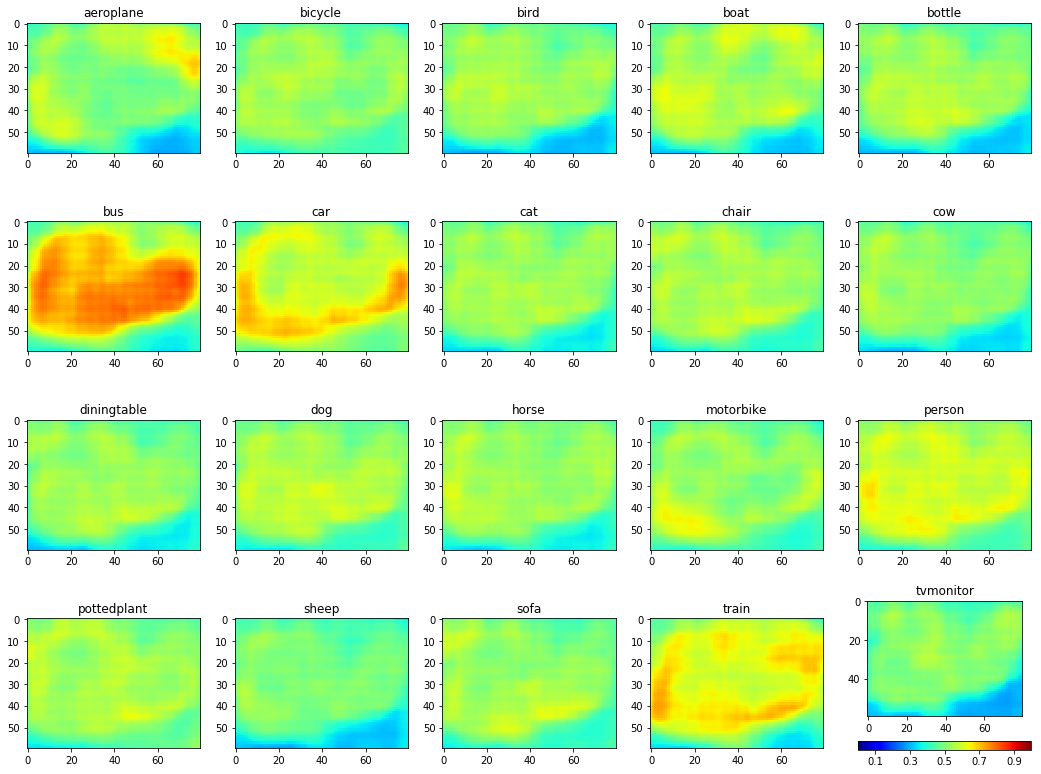

In [121]:
%time preds_dist = textureDetect(featuremaps, filter_size=(3,3), upsample=True, upsample_scale=5)
plotHeatMap(preds_dist)

In [141]:
preds_dist.cpu().numpy().transpose([1,2,0]).shape
# # 96000/4,96000/5
# (96000/20)**.5

(60, 80, 20)

In [104]:
[p.mean().item() for p in  preds_dist]

[0.5086485147476196,
 0.5119064450263977,
 0.49713197350502014,
 0.5282720327377319,
 0.503593921661377,
 0.6479470729827881,
 0.5973351001739502,
 0.5087640285491943,
 0.5234102606773376,
 0.49258700013160706,
 0.5033407807350159,
 0.5307604670524597,
 0.5141870975494385,
 0.5188378691673279,
 0.573664665222168,
 0.5332969427108765,
 0.46614640951156616,
 0.5168646574020386,
 0.597674548625946,
 0.47441962361335754]

---
# mean Average Precision
- 클래스별로 AP구한뒤 평균
- AP구하기 위해 실제 bbox개수(Ground truth), confidience, True postive(50% IOU) 기록
- sort by confidence
- calculate precision, recall

[class]: aeroplane , [AP]: 0.17112384917891116
[Precisions] [1.         0.43362832 0.29518072 0.1535533  0.         0.
 0.         0.         0.         0.         0.        ]


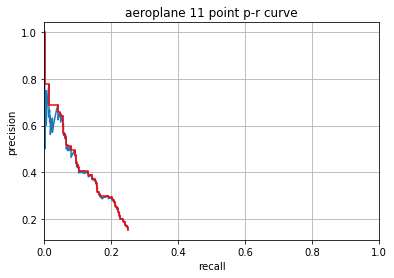

[class]: bicycle , [AP]: 0.2260199740053395
[Precisions] [1.         0.64788732 0.4619883  0.37634409 0.         0.
 0.         0.         0.         0.         0.        ]


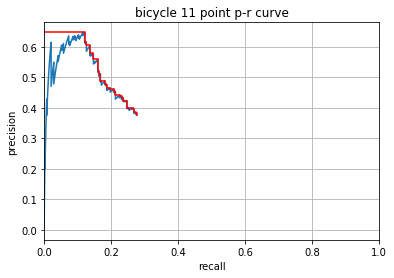

[class]: bird , [AP]: 0.13566433566433567
[Precisions] [1.         0.24615385 0.24615385 0.         0.         0.
 0.         0.         0.         0.         0.        ]


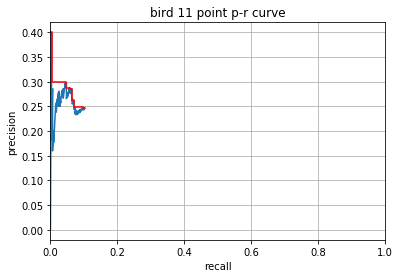

[class]: boat , [AP]: 0.13098938098938098
[Precisions] [1.         0.25       0.19088319 0.         0.         0.
 0.         0.         0.         0.         0.        ]


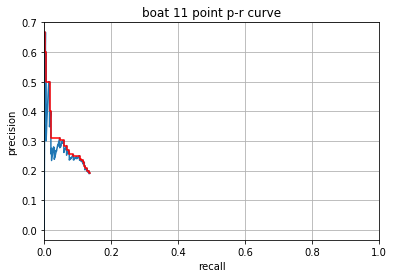

[class]: bottle , [AP]: 0.111155220325526
[Precisions] [1.         0.22270742 0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


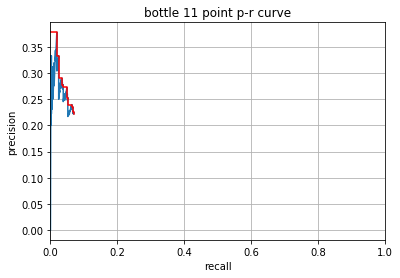

[class]: bus , [AP]: 0.423111699338668
[Precisions] [1.         0.8627451  0.85897436 0.83471074 0.75438596 0.34341253
 0.         0.         0.         0.         0.        ]


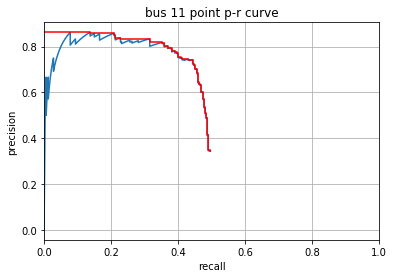

[class]: car , [AP]: 0.20865322589553584
[Precisions] [1.         0.63874346 0.3460972  0.31034483 0.         0.
 0.         0.         0.         0.         0.        ]


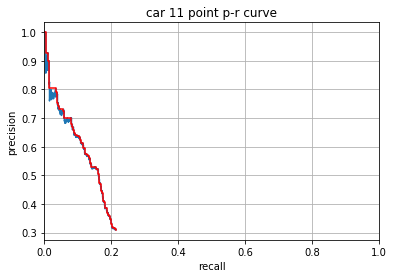

[class]: cat , [AP]: 0.15110641095511207
[Precisions] [1.         0.35840708 0.30376344 0.         0.         0.
 0.         0.         0.         0.         0.        ]


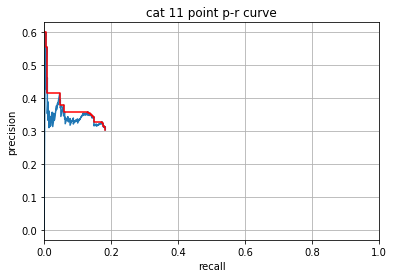

[class]: chair , [AP]: 0.1041868579182012
[Precisions] [1.         0.14605544 0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


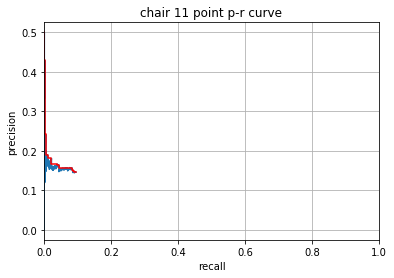

[class]: cow , [AP]: 0.2327500521025378
[Precisions] [1.         0.55102041 0.52238806 0.48684211 0.         0.
 0.         0.         0.         0.         0.        ]


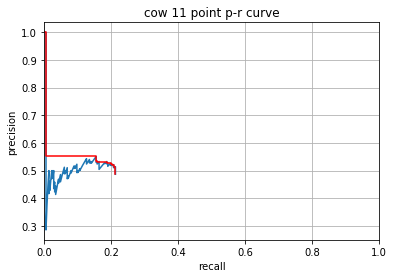

[class]: diningtable , [AP]: 0.21033955686362102
[Precisions] [1.         0.56756757 0.40106952 0.34509804 0.         0.
 0.         0.         0.         0.         0.        ]


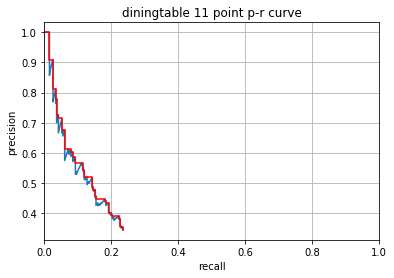

[class]: dog , [AP]: 0.18936758951769567
[Precisions] [1.         0.39593909 0.35307517 0.33402923 0.         0.
 0.         0.         0.         0.         0.        ]


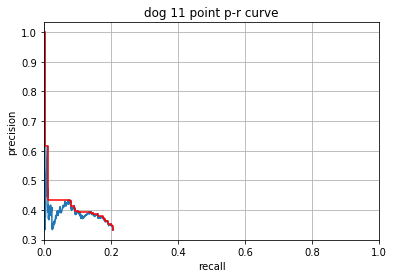

[class]: horse , [AP]: 0.20421970429319306
[Precisions] [1.         0.52054795 0.37128713 0.35458167 0.         0.
 0.         0.         0.         0.         0.        ]


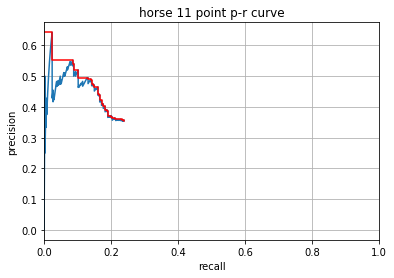

[class]: motorbike , [AP]: 0.31107011574731847
[Precisions] [1.         0.78333333 0.64957265 0.56930693 0.41955836 0.
 0.         0.         0.         0.         0.        ]


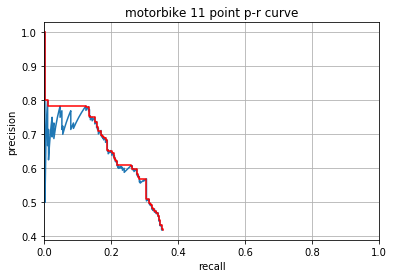

[class]: person , [AP]: 0.1441798014775633
[Precisions] [1.         0.31840796 0.26756986 0.         0.         0.
 0.         0.         0.         0.         0.        ]


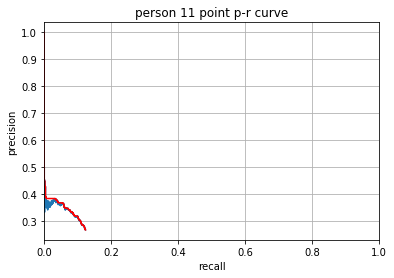

[class]: pottedplant , [AP]: 0.11049519586104951
[Precisions] [1.         0.21544715 0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


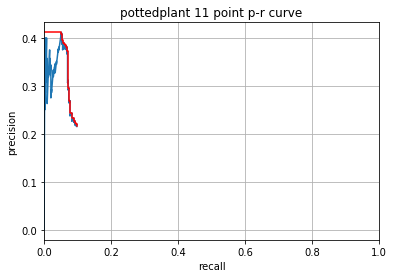

[class]: sheep , [AP]: 0.1304812834224599
[Precisions] [1.         0.43529412 0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


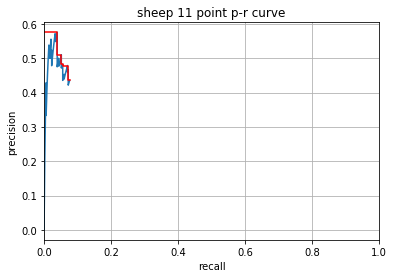

[class]: sofa , [AP]: 0.19554342268740382
[Precisions] [1.         0.44086022 0.3804878  0.32962963 0.         0.
 0.         0.         0.         0.         0.        ]


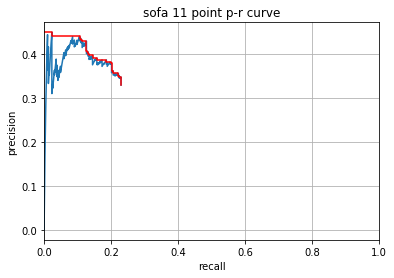

[class]: train , [AP]: 0.2149503790468872
[Precisions] [1.         0.44594595 0.37560976 0.33544304 0.20745543 0.
 0.         0.         0.         0.         0.        ]


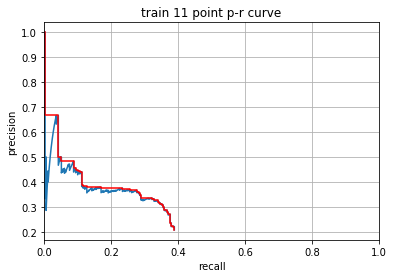

[class]: tvmonitor , [AP]: 0.3232218971694065
[Precisions] [1.         0.72368421 0.6484375  0.50813008 0.37668161 0.29850746
 0.         0.         0.         0.         0.        ]


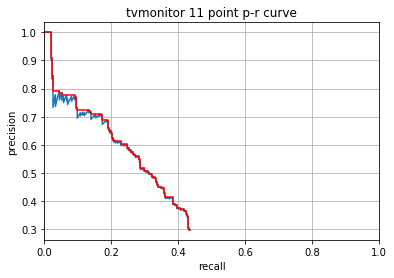

0.19643149762300732

In [214]:
from collections import Counter
# https://github.com/rafaelpadilla/Object-Detection-Metrics

def calc_AP(dataset_classes, label, target_all, dfs):
    target = dataset_classes.index(label)
    n_gt = Counter(target_all)

    _df = dfs[label].sort_values(by='confidience', ascending=False) # sort by conf

    _df['FP'] = [0 if tp==1 else 1 for tp in _df['TP']]
    _df['cum_TP'] = _df['TP'].cumsum()
    _df['cum_FP'] = _df['FP'].cumsum()
    _df['precision'] = [tp/(tp+fp) for tp,fp in zip(_df['cum_TP'],_df['cum_FP'])]
    _df['recall'] = _df['cum_TP']/n_gt[target]
    _df['precision_interpolated'] = [_df['precision'][i:].max() for i in range(len(_df['recall']))] 
    _df.reset_index(inplace=True)

    precisions = [_df['precision_interpolated'][_df['recall'].between(0.1*(i-1),0.1*i,inclusive=True)].min() for i in range(11)]
    precisions[0] = 1
    precisions = np.array([0 if p is np.nan else p for p in precisions])
    AP = precisions.mean()
    print('[class]:', label, ', [AP]:', AP)
    print('[Precisions]', precisions)

    plt.plot(_df['recall'], _df['precision'])
    plt.plot(_df['recall'], _df['precision_interpolated'], color='r')
    plt.grid()
    plt.xlim([0,1]), plt.title(label+' 11 point p-r curve')
    plt.xlabel('recall'), plt.ylabel('precision')
    plt.show()

    # display(_df)
    return AP, _df
    
# AP_list = np.array([calc_AP(t)[0] for t in voc_classes])

AP_list = []
df_res_list = {}
for cls in voc_classes:
    AP, df_res = calc_AP(voc_val_dataset.classes, cls, target_all, dfs)
    AP_list.append(AP)
    df_res_list[cls] = df_res
AP_list = np.array(AP_list)

mAP = AP_list.mean()
mAP

In [215]:
list(zip(voc_classes, AP_list))

[('aeroplane', 0.17112384917891116),
 ('bicycle', 0.2260199740053395),
 ('bird', 0.13566433566433567),
 ('boat', 0.13098938098938098),
 ('bottle', 0.111155220325526),
 ('bus', 0.423111699338668),
 ('car', 0.20865322589553584),
 ('cat', 0.15110641095511207),
 ('chair', 0.1041868579182012),
 ('cow', 0.2327500521025378),
 ('diningtable', 0.21033955686362102),
 ('dog', 0.18936758951769567),
 ('horse', 0.20421970429319306),
 ('motorbike', 0.31107011574731847),
 ('person', 0.1441798014775633),
 ('pottedplant', 0.11049519586104951),
 ('sheep', 0.1304812834224599),
 ('sofa', 0.19554342268740382),
 ('train', 0.2149503790468872),
 ('tvmonitor', 0.3232218971694065)]

In [216]:
from IPython.core.display import HTML
display(HTML(df_res_list['aeroplane'].to_html()))

,index,image,confidience,TP,IOU,FP,cum_TP,cum_FP,precision,recall,precision_interpolated
0,531,2011_002494.jpg,0.259546,1,0.694397,0,1,0,1.000000,0.00206612,1.000000
1,501,2008_002358.jpg,0.254539,0,0.475753,1,1,1,0.500000,0.00206612,0.777778
2,25,2008_003905.jpg,0.247720,1,0.809906,0,2,1,0.666667,0.00413223,0.777778
3,595,2009_001387.jpg,0.244615,1,0.706933,0,3,1,0.750000,0.00619835,0.777778
4,515,2009_000397.jpg,0.242764,0,0.428942,1,3,2,0.600000,0.00619835,0.777778
5,5,2010_003279.jpg,0.239685,1,0.635280,0,4,2,0.666667,0.00826446,0.777778
6,470,2009_002211.jpg,0.236171,1,0.933892,0,5,2,0.714286,0.0103306,0.777778
7,629,2008_008278.jpg,0.235677,1,0.789333,0,6,2,0.750000,0.0123967,0.777778
8,639,2011_000592.jpg,0.233313,1,0.577009,0,7,2,0.777778,0.0144628,0.777778
9,718,2008_002151.jpg,0.231802,0,0.484860,1,7,3,0.700000,0.0144628,0.700000


In [482]:
dd = torchvision.datasets.VOCDetection(root='./data', year='2007', 
                                       image_set='test', download=False, transform=None)
len(dd)

4952

In [229]:
import selectivesearch

In [259]:
# frame.shape
scale=1
frame = cv2.imread(".\\ttt.jpg")
frame = cv2.resize(frame, (int(frame.shape[1]*scale), int(frame.shape[0]*scale)), 
                              interpolation=cv2.INTER_CUBIC).astype(np.uint8)
%time img_lbl, regions = selectivesearch.selective_search(frame, scale=500, sigma=0.9, min_size=255)

print(len(regions))

for idx, b in enumerate(regions[:100]):
    x1, x2, y1, y2 = b['rect']
    cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 0), 1)   
    
cv2.imshow('frame',frame)
cv2.waitKey(0)
cv2.destroyAllWindows()      

Wall time: 2.6 s
167


In [254]:
img_lbl.shape
frame.shape
len(regions)
regions[0]
cv2.destroyAllWindows()      

---
# MS-COCO

In [47]:
coco_val_path="./data/coco2017/val2017"
coco_json="./data/coco2017/annotations/instances_val2017.json"

In [71]:
coco_val_dataset = torchvision.datasets.CocoDetection(root = coco_val_path,
                                annFile = coco_json)

coco_val_loader = torch.utils.data.DataLoader(voc_val_dataset, batch_size=1,
                                          shuffle=True, num_workers=4)

loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


In [85]:
print('Number of samples: ', len(coco_val_dataset))

coco_labels = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", 
               "train", "truck", "boat", "traffic light", "fire hydrant", "-",
               "stop sign", "parking meter", "bench", "bird", "cat", "dog", 
               "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "-", 
               "backpack", "umbrella", "-", "-", "handbag", "tie", "suitcase", "frisbee", 
               "skis", "snowboard", "sports ball", "kite", "baseball bat", 
               "baseball glove", "skateboard", "surfboard", "tennis racket", 
               "bottle", "-", "wine glass", "cup", "fork", "knife", "spoon", "bowl", 
               "banana", "apple", "sandwich", "orange", "broccoli", "carrot", 
               "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant", 
               "bed", "-", "dining table", "-", "-", "toilet", "-", "tv", "laptop", "mouse", "remote", 
               "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", 
               "refrigerator", "-", "book", "clock", "vase", "scissors", "teddy bear", 
               "hair drier", "toothbrush", "-"]

Number of samples:  5000


In [91]:
for img, anno in coco_val_dataset:
    frame = np.array(img)[:,:,::-1].copy() # RGB -> BGR for opencv
    boxes = np.array([an['bbox'] for an in anno], dtype=np.int)
    labels = [coco_labels[an['category_id']-1] for an in anno]
    for label, b in zip(labels, boxes):
        x, y, w, h = b
        cv2.putText(frame, label, (x+3, y+17), cv2.FONT_HERSHEY_SIMPLEX, .6, (0,0,225), 2)        
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        

    cv2.imshow("coco", frame)
    k = cv2.waitKey(0) & 0xff 
    if k == 27: # esc
        break
            
cv2.destroyAllWindows()  


---
# FSOD

In [7]:
import pickle
import pandas as pd
import cv2
import os

In [4]:
df = pd.read_pickle('data/FSOD/all_images/fsod_train_df.pkl')
df2 = pd.read_pickle('data/FSOD/all_images/fsod_test_df.pkl')

In [5]:
# 클래스 안겹침
len(set(df['category_name'])), len(set(df2['category_name']))

(800, 200)

In [6]:
df

,father_category,image_path,image_name,dataset,width,bbox,height,category_name
0,cosmetics,./all_images/part_2/train_part_e/e8/e8fe15d38a...,e8fe15d38a65c26b,openimage,1024.0,"[393, 347, 48, 42]",719.0,lipstick
1,footwear,./all_images/part_2/train_part_0/01/01b690a4a6...,01b690a4a6435003,openimage,1024.0,"[163, 165, 52, 99]",576.0,sandal
2,reptile,./all_images/part_2/train_part_8/80/8065c75e1b...,8065c75e1b66ae7f,openimage,1024.0,"[0, 65, 972, 444]",576.0,crocodile
3,helmet,./all_images/part_2/train_part_0/06/06c25b6c06...,06c25b6c06309455,openimage,1024.0,"[702, 262, 44, 37]",686.0,football helmet
4,fashion accessory,./all_images/part_2/train_part_7/79/79acb7db73...,79acb7db73f3a1c8,openimage,1024.0,"[750, 178, 103, 51]",633.0,umbrella
5,mammal,./all_images/part_1/n02422106/n02422106_40.jpg,n02422106_40,imagenet,300.0,"[40, 11, 154, 188]",200.0,hartebeest
6,plant,./all_images/part_2/train_part_d/dc/dce1e03a29...,dce1e03a29631a91,openimage,1024.0,"[220, 137, 104, 167]",685.0,houseplant
7,electronic product,./all_images/part_1/n03777754/n03777754_4052.jpg,n03777754_4052,imagenet,500.0,"[0, 82, 441, 290]",375.0,modem
8,mammal,./all_images/part_2/train_part_1/19/192bf7f821...,192bf7f821989514,openimage,1024.0,"[362, 370, 58, 147]",768.0,antelope
9,bird,./all_images/part_2/train_part_7/78/789e4a4d45...,789e4a4d45b7c8f5,openimage,662.0,"[363, 139, 258, 402]",1024.0,woodpecker


In [31]:
# num = 28
for i in df.index[100:200]:
    num = i
    fp = os.path.join('data', 'FSOD',df['image_path'][num])
    im = cv2.imread(fp)

    _df = df[df['image_path'] == df['image_path'][num]]
    cates = _df['category_name']
    boxes = _df['bbox']

    for b, c in zip(boxes, cates):
        x, y, w, h = b
        cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        cv2.putText(im, c, (x+3, y+17), cv2.FONT_HERSHEY_SIMPLEX, .6, (0,0,225), 2)

    cv2.imshow("FSOD", im)
    cv2.waitKey(1000)
    cv2.destroyAllWindows()        